This notebook is just meant to test the codes before I compile them as .py files.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.io.ascii as astropy_ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from src.utils.constants import *

from scipy.stats import norm
from scipy.optimize import curve_fit

GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'

# 1. Fetch coordinates (ra, dec) from raw data

In [ ]:
# 6dFGS
df = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)

# ra is still in hour -> need to convert to degrees
df_test = df[['ra', 'dec']]

In [ ]:
Table.from_pandas(df_test).write('6dfgs_coord.ascii', format='ipac', overwrite=True)

In [ ]:
# LAMOST
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df = pd.DataFrame(hdul[1].data)

df[['ra', 'dec']].describe()

In [ ]:
# # sdss
# df = pd.read_csv('data/raw/sdss/SDSS_spectro_mrafifrbbn.csv')

# df[['ra', 'dec']].describe()

# 2. Merge the spectroscopy and photometry

In [ ]:
# Compare the original raw data to 2MASS (check if the order is the same)
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost_spectro = pd.DataFrame(hdul[1].data)
    
df_lamost_tmass = pd.read_csv('data/raw/2mass/lamost_tmass.csv', low_memory=False)

df = pd.merge(df_lamost_spectro[['ra', 'dec']], df_lamost_tmass[['ra_01', 'dec_01']], left_index=True, right_index=True)

df['delta_ra'] = df['ra_01']-df['ra']
df['delta_dec'] = df['dec_01']-df['dec']


df[['delta_ra', 'delta_dec']].describe()

In [ ]:
# Compare the original raw data to 2MASS
df_6df_spectro = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)
df_6df_spectro['ra'] = df_6df_spectro['ra']*15

df_6df_tmass = pd.read_csv('data/raw/2mass/6dfgs_tmass.csv', low_memory=False)

df = pd.merge(df_6df_spectro[['ra', 'dec']], df_6df_tmass[['ra_01', 'dec_01']], left_index=True, right_index=True)

df['delta_ra'] = df['ra_01']-df['ra']
df['delta_dec'] = df['dec_01']-df['dec']

df[['delta_ra', 'delta_dec']].describe()

# Coba2 cross-matching

In [ ]:
# LAMOST
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost = Table(hdul[1].data).to_pandas()

df_sdss = pd.read_csv('data/raw/sdss/SDSS_spectro_mrafifrbbn.csv')

In [ ]:
sdss_coords = SkyCoord(ra=df_sdss['ra'].to_numpy()*u.deg, dec=df_sdss['dec'].to_numpy()*u.deg)
lamost_coords = SkyCoord(ra=df_lamost['ra'].to_numpy()*u.deg, dec=df_lamost['dec'].to_numpy()*u.deg)

In [ ]:
idx, sep2d, _ = lamost_coords.match_to_catalog_sky(sdss_coords)
is_counterpart = sep2d < 1.*u.arcsec

df_lamost['sdss_idx'] = idx
df_lamost['sdss_counterpart'] = is_counterpart

df_lamost = df_lamost[df_lamost['sdss_counterpart']==True]

In [ ]:
df_lamost_sdss = df_lamost.merge(df_sdss, left_on='sdss_idx', right_index=True)

In [ ]:
df_lamost_sdss[['ra_x', 'dec_x', 'ra_y', 'dec_y', 'veldisp_x', 'sigmaStars']]

## Main code for merging

### 6dFGS: Combine Vizier data (what I used throughout my thesis)

In [ ]:
# FP data
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_fp = Table(hdul[1].data).to_pandas()
    
df_fp.head()

In [ ]:
# veldisp data
with fits.open('data/raw/6dfgs/sdfgs_veldisp_vizier.fits') as hdul:
    df_veldisp = Table(hdul[1].data).to_pandas()

veldisp_columns = ['_6dFGS', 'MJD', 'z', 'S_N', 'R', 'Vd', 'e_Vd', '_RA', '_DE']
df_veldisp = df_veldisp[veldisp_columns]

df_veldisp.head()

In [ ]:
df_6dfgs = df_fp.merge(df_veldisp, on='_6dFGS', how='inner')

df_6dfgs

In [ ]:
df_6df_campbell = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)[['6dFGSid', 'ra', 'dec']]
df_6df_campbell['ra'] = df_6df_campbell['ra']

In [ ]:
df_compare = df_6dfgs.merge(df_6df_campbell, left_on='_6dFGS', right_on='6dFGSid')
df_compare['DELTA_RA'] = (df_compare['RAJ2000']-df_compare['ra'])*15*3600
df_compare['DELTA_DE'] = (df_compare['DEJ2000']-df_compare['dec'])*3600
df_compare[['RAJ2000', 'DEJ2000', 'ra', 'dec', 'DELTA_RA', 'DELTA_DE']]

In [ ]:
# Selidiki perbedaan ra_01 dec_01 (input) dan ra dan dec (dari 2MASS)
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra_01'].to_numpy()*u.deg, dec=df['dec_01'].to_numpy()*u.deg)
coords_2 = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_2)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

In [ ]:
# Selidiki perbedaan ra_01 dec_01 dan sup_ra dan sup_dec
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra_01'].to_numpy()*u.deg, dec=df['dec_01'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df['sup_ra'].to_numpy()*u.deg, dec=df['sup_dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_sup)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

In [ ]:
max(sep2d.arcsec)

In [ ]:
len(df)

In [ ]:
# Selidiki perbedaan ra dec dan sup_ra dan sup_dec
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df['sup_ra'].to_numpy()*u.deg, dec=df['sup_dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_sup)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

##### Eksperimen mau pake ra dec atau sup_ra dan sup_dec (dan berapa threshold yang optimal)

In [ ]:
# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']
    
# Ambil data 2MASS (11117 galaksi)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')[['designation', 'ra_01', 'dec_01', 'ra', 'dec', 'sup_ra', 'sup_dec']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']

# Find the extra 15 galaxies
dfe = pd.merge(df_2mass, df_6df, how='left', on='_2MASX', indicator=True).query('_merge=="left_only"')

# Store the coordinates
coords_ori = SkyCoord(ra=dfe['ra_01'].to_numpy()*u.deg, dec=dfe['dec_01'].to_numpy()*u.deg)
coords_radec = SkyCoord(ra=dfe['ra'].to_numpy()*u.deg, dec=dfe['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=dfe['sup_ra'].to_numpy()*u.deg, dec=dfe['sup_dec'].to_numpy()*u.deg)

f, (ax1, ax2) = plt.subplots(nrows=2)

# Find the separation between ra_01 dec_01 (original data) with ra dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_radec)
print(f'Min sep2d with ra and dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with ra and dec: {max(sep2d.arcsec)}')
ax1.hist(sep2d.arcsec)
ax1.set_title('Sep2d for the extra 15 galaxies with ra and dec')

print('\n')

# Find the separation between ra_01 dec_01 (original data) with sup_ra and sup_dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
print(f'Min sep2d with sup_ra and sup_dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with sup_ra and sup_dec: {max(sep2d.arcsec)}')
ax2.hist(sep2d.arcsec)
ax2.set_title('Sep2d for the extra 15 galaxies with sup_ra and sup_dec')

f.tight_layout()
plt.show()

In [ ]:
# Find the common 11102 galaxies
dfe = pd.merge(df_2mass, df_6df, how='left', on='_2MASX', indicator=True).query('_merge=="both"')

# Store the coordinates
coords_ori = SkyCoord(ra=dfe['ra_01'].to_numpy()*u.deg, dec=dfe['dec_01'].to_numpy()*u.deg)
coords_radec = SkyCoord(ra=dfe['ra'].to_numpy()*u.deg, dec=dfe['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=dfe['sup_ra'].to_numpy()*u.deg, dec=dfe['sup_dec'].to_numpy()*u.deg)

f, (ax1, ax2) = plt.subplots(nrows=2)

# Find the separation between ra_01 dec_01 (original data) with ra dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_radec)
print(f'Min sep2d with ra and dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with ra and dec: {max(sep2d.arcsec)}')
ax1.hist(sep2d.arcsec, bins=100)
ax1.set_title('Sep2d for the extra 15 galaxies with ra and dec')

print('\n')

# Find the separation between ra_01 dec_01 (original data) with sup_ra and sup_dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
print(f'Min sep2d with sup_ra and sup_dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with sup_ra and sup_dec: {max(sep2d.arcsec)}')
ax2.hist(sep2d.arcsec, bins=100)
ax2.set_title('Sep2d for the extra 15 galaxies with sup_ra and sup_dec')

f.tight_layout()
plt.show()

In [ ]:
# Try out the pipeline (from the original, cross-match with sup_ra and sup_dec and select sep2d < 2.5 arcsec)

# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'Jtot', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']

# Ambil data 2MASS (11117 galaksi)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')[['designation', 'sup_ra', 'sup_dec', 'j_m_ext', 'j_ba']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']
df_2mass = df_2mass.sort_values(by='j_m_ext').reset_index()

# Ambil koordinatnya
coords_ori = SkyCoord(ra=df_6df['RAJ2000'].to_numpy()*u.deg, dec=df_6df['DEJ2000'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df_2mass['sup_ra'].to_numpy()*u.deg, dec=df_2mass['sup_dec'].to_numpy()*u.deg)

# Sky cross-matching
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
SEP_THRESH = 10.
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df_6df['tmass_idx'] = idx
df_6df['tmass_counterpart'] = is_counterpart

# df_6df = df_6df[df_6df['tmass_counterpart']==True]

df = df_6df.merge(df_2mass, left_on='tmass_idx', right_index=True)

df

##### Eksperimen apakah bisa langsung one-to-one match aja

In [ ]:
# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'Jtot', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']

# Ambil data 2MASS (11102 galaksi juga)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_one_to_one.csv')#[['designation', 'sup_ra', 'sup_dec', 'j_m_ext', 'j_ba']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']

# Merge by index
df = df_6df.merge(df_2mass, left_index=True, right_index=True)

plt.hist(df['dist_x'], bins=100)
plt.show()

In [34]:
pd.read_csv(SDFGS_MAGOULAS_FP_SAMPLE, delim_whitespace=True)

,#6dFGS_ID,r,s,i,dr,dr_ph,ds,di,Sprob,cz
0,g0000144-765225,0.465,2.137,2.940,0.057,0.008,0.073,0.084,1.000,15941.0
1,g0000222-013746,0.024,2.338,3.708,0.048,0.012,0.023,0.071,1.000,11123.0
2,g0000235-065610,0.343,2.219,3.067,0.047,0.012,0.045,0.070,1.000,10920.0
3,g0000251-260240,0.371,2.369,3.328,0.046,0.009,0.040,0.068,1.000,14926.0
4,g0000356-014547,0.316,2.144,2.859,0.042,0.018,0.066,0.062,0.538,6956.0
...,...,...,...,...,...,...,...,...,...,...
8798,g2358598-552730,0.367,2.409,3.262,0.032,0.039,0.015,0.048,1.000,3160.0
8799,g2358599-620048,0.253,2.139,3.204,0.042,0.014,0.028,0.062,1.000,8954.0
8800,g2359035-052419,0.161,2.172,3.254,0.047,0.015,0.070,0.069,0.714,8819.0
8801,g2359193-314348,0.292,2.295,3.064,0.041,0.016,0.032,0.060,0.930,8111.0


## MERGING 6dFGS DATA

In [35]:
SDFGS_FP_FILEPATH = 'data/raw/6dfgs/sdfgs_fp_vizier.fits'
SDFGS_TMASS_FILEPATH = 'data/raw/2mass/sdfgs_tmass.csv'
SDFGS_VELDISP_FILEPATH = 'data/raw/6dfgs/sdfgs_veldisp_vizier.fits'
SDFGS_MAGOULAS_FP_SAMPLE = 'data/external/ETG_sample/fp_magoulas.txt'

# Vizier first table (FP sample)
print('Opening the 6dFGS FP sample...')
req_cols = ['_2MASX', 'Jlogr', 'n', 'Hlogr', 'Klogr', '_6dFGS', 'RAJ2000', 
            'DEJ2000', 'cz', 'Mt', 'Group', 'Nr', 'Ng', 'cz_gr']
with fits.open(SDFGS_FP_FILEPATH) as hdul:
    df_fp = Table(hdul[1].data).to_pandas()[req_cols]
    df_fp['RAJ2000'] *= 15

# Open the 2MASS data
print('Opening the 2MASS photometry data...')
req_cols = ['ra_01', 'dec_01', 'designation', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
            'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff']
df_2mass = pd.read_csv(SDFGS_TMASS_FILEPATH)[req_cols]

# Merge FP + 2MASS
print('Merging 6dFGS FP data with 2MASS data...')
df = df_fp.merge(df_2mass, left_index=True, right_index=True)

# Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
max_delta_ra = np.absolute(max(df['RAJ2000'] - df['ra_01']))
max_delta_dec = np.absolute(max(df['DEJ2000'] - df['dec_01']))
tol_ = 0.001
print(f'Max delta RA: {max_delta_ra}')
print(f'Max delta DEC: {max_delta_dec}')

if (max_delta_ra > tol_) or (max_delta_dec > tol_):
    print('The two tables do not match.')
    raise
else:
    print('The coordinates in 6dFGS FP and 2MASS are consistent.')
    df = df.drop(['ra_01', 'dec_01'], axis=1)

# Vizier second table (veldisp data)
print('Opening the 6dFGS veldisp data...')
req_cols = ['_2MASX', 'MJD', 'z', 'S_N', 'Vd', 'e_Vd']
with fits.open(SDFGS_VELDISP_FILEPATH) as hdul:
    df_veldisp = Table(hdul[1].data).to_pandas()[req_cols]

## Drop duplicated rows (select the one with the highest S_N)
df_veldisp = df_veldisp.sort_values(by='S_N', ascending=False)
df_veldisp = df_veldisp.drop_duplicates(subset='_2MASX')

# Merge the with the velocity dispersion data
print('Merging the 6dFGS veldisp data...')
df = df.merge(df_veldisp, on='_2MASX')

# Select Christina's FP sample (8803 galaxies)
print("Opening Christina's FP sample and performing inner join...")
df_magoulas = pd.read_csv(SDFGS_MAGOULAS_FP_SAMPLE, delim_whitespace=True)[['#6dFGS_ID']]
df_magoulas = df_magoulas.rename({'#6dFGS_ID': '_6dFGS'}, axis=1)
df = df.merge(df_magoulas, on='_6dFGS', how='inner')

df

Opening the 6dFGS FP sample...
Opening the 2MASS photometry data...
Merging 6dFGS FP data with 2MASS data...
Max delta RA: 0.0
Max delta DEC: 1.4210854715202004e-14
The coordinates in 6dFGS FP and 2MASS are consistent.
Opening the 6dFGS veldisp data...


,_2MASX,Jlogr,n,Hlogr,Klogr,_6dFGS,RAJ2000,DEJ2000,cz,Mt,...,h_m_ext,k_m_ext,j_r_eff,h_r_eff,k_r_eff,MJD,z,S_N,Vd,e_Vd
0,J00001440-7652248,0.605,5.43,0.503,0.401,g0000144-765225,0.05985,-76.87364,15941,2.2,...,12.490,12.206,5.23,4.46,3.49,53614.60,0.0533,13.200000,129.000000,21.700001
1,J00002213-0137463,0.312,4.52,0.278,0.201,g0000222-013746,0.09225,-1.62947,11123,2.5,...,11.896,11.741,2.98,2.94,2.60,52962.44,0.0383,24.100000,199.100006,10.500000
2,J00002348-0656103,0.638,6.00,0.665,0.428,g0000235-065610,0.09780,-6.93619,10920,3.7,...,11.857,11.869,5.72,6.03,3.63,52966.46,0.0376,15.200000,156.199997,16.200001
3,J00002509-2602401,0.538,3.59,0.505,0.477,g0000251-260240,0.10455,-26.04450,14926,2.3,...,11.781,11.553,4.60,4.25,3.93,52846.78,0.0508,13.200000,218.500000,20.100000
4,J00003564-0145472,0.800,3.24,0.770,0.804,g0000356-014547,0.14850,-1.76317,6956,3.0,...,11.605,11.281,7.44,7.01,7.58,52962.44,0.0244,14.000000,133.399994,20.299999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8798,J23585980-5527301,1.187,4.30,1.164,1.174,g2358598-552730,359.74905,-55.45833,3160,0.0,...,8.554,8.272,16.75,15.86,16.21,52969.51,0.0111,36.099998,254.899994,8.800000
8799,J23585991-6200483,0.631,4.54,0.622,0.579,g2358599-620048,359.74965,-62.01342,8954,0.0,...,11.547,11.361,5.40,5.35,4.95,52961.44,0.0303,28.200001,129.899994,8.400000
8800,J23590350-0524185,0.545,6.00,0.549,0.518,g2359035-052419,359.76450,-5.40517,8819,2.0,...,11.829,11.580,5.30,5.30,4.96,52966.46,0.0306,11.800000,139.100006,22.400000
8801,J23591929-3143478,0.712,4.98,0.660,0.745,g2359193-314348,359.83050,-31.72992,8111,4.0,...,11.519,11.104,7.34,6.58,7.74,52876.71,0.0280,20.900000,187.199997,13.800000


# MERGING SDSS DATA

In [68]:
# compare cullan's data with original DR14 data
df_mydata = pd.read_csv('data/raw/sdss/SDSS_spectro_20240219_02_mrafifrbbn.csv')#[['objID', 'ra', 'dec', 'z', 'zErr', 'sigmaStars', 'sigmaStarsErr']]
df_cullan = pd.read_csv('data/raw/sdss/sdss_howlett2022.dat', delim_whitespace=True)#[['objid', 'RA', 'Dec', 'zhelio', 'zhelioerr', 'SIGMA_STARS', 'SIGMA_STARS_ERR']]

df = df_mydata.merge(df_cullan, left_on='objID', right_on='objid', how='inner')

df['delta_ra'] = (df['ra'] - df['RA'])*3600
df['delta_dec'] = (df['dec'] - df['Dec'])*3600
df['delta_z'] = df['z'] - df['zhelio']
df['delta_z_err'] = df['zErr'] - df['zhelioerr']
df['delta_veldisp'] = df['sigmaStars'] - df['SIGMA_STARS']
df['delta_veldisp_err'] = df['sigmaStarsErr'] - df['SIGMA_STARS_ERR']

df[['delta_ra', 'delta_dec', 'delta_z', 'delta_z_err', 'delta_veldisp', 'delta_veldisp_err']].describe()

,delta_ra,delta_dec,delta_z,delta_z_err,delta_veldisp,delta_veldisp_err
count,30284.000000,30284.000000,3.028400e+04,3.028400e+04,30284.000000,30284.000000
mean,0.019101,0.007932,-1.868809e-09,-5.728984e-09,-0.000872,-0.002297
std,0.066254,0.048721,9.135182e-07,1.935702e-07,0.273670,0.077360
min,-1.594800,-1.171080,-4.199000e-05,-8.310410e-06,-18.004120,-3.530973
25%,-0.007200,-0.014400,-2.500000e-07,-2.000000e-11,-0.000020,-0.000002
50%,0.021600,0.007200,0.000000e+00,0.000000e+00,0.000000,0.000000
75%,0.046800,0.028800,2.500000e-07,2.000000e-11,0.000020,0.000002
max,1.353600,1.260000,6.376000e-05,8.380590e-06,13.234330,3.114434


In [67]:
df = pd.read_csv('data/scrap/test1_mrafifrbbn.csv')

df['delta_ra'] = (df['ra_photo'] - df['RA'])*3600
df['delta_dec'] = (df['dec_photo'] - df['Dec'])*3600
df['delta_z'] = df['z'] - df['zhelio']
df['delta_z_err'] = df['zErr'] - df['zhelioerr']
df['delta_veldisp'] = df['sigmaStars'] - df['SIGMA_STARS']
df['delta_veldisp_err'] = df['sigmaStarsErr'] - df['SIGMA_STARS_ERR']

df[['delta_ra', 'delta_dec', 'delta_z', 'delta_z_err', 'delta_veldisp', 'delta_veldisp_err']].describe()

,delta_ra,delta_dec,delta_z,delta_z_err,delta_veldisp,delta_veldisp_err
count,23058.000000,23058.000000,2.305800e+04,2.305800e+04,2.305800e+04,2.305800e+04
mean,-0.001411,-0.000020,3.417903e-10,-7.468124e-14,1.864863e-08,-1.396478e-08
std,0.104805,0.009542,2.884416e-07,2.793709e-11,4.684114e-06,2.903065e-06
min,-0.208649,-0.030555,-5.000000e-07,-5.000000e-11,-1.000000e-04,-1.000000e-05
25%,-0.090300,-0.006506,-2.500000e-07,-2.000000e-11,0.000000e+00,-2.000000e-06
50%,-0.001905,-0.000004,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.087998,0.006310,2.500000e-07,2.000000e-11,0.000000e+00,2.000000e-06
max,0.216067,0.028450,5.000000e-07,5.000000e-11,1.000000e-04,1.000000e-05


In [93]:
['objid', 'specObjId', 'RA', 'Dec', 'zhelio', 'zhelioerr', 'SIGMA_STARS', 'SIGMA_STARS']

df = pd.read_csv('data/raw/sdss/sdss_howlett2022.dat', delim_whitespace=True)

df.columns

Index(['PGC', 'coords', 'objid', 'specObjId', 'plate', 'RA', 'Dec', 'l', 'b',
       'deVMag_g', 'deVMagErr_g', 'deVMagErr_r', 'deVMagErr_r.1', 'deVRad_r',
       'deVRadErr_r', 'deVAB_r', 'deVABErr_r', 'extinction_g', 'extinction_r',
       'kcor_r', 'kcor_g', 'absmag_r', 'zhelio', 'zhelioerr', 'zcmb',
       'SIGMA_STARS', 'SIGMA_STARS_ERR', 'IDgroupT17', 'NgroupT17',
       'zcmb_group', 'M', 'in_mask', 'nbar', 'r', 'er', 's', 'es', 'i', 'ei',
       'logdist', 'logdist_err', 'logdist_alpha', 'logdist_corr',
       'logdist_corr_err', 'logdist_corr_alpha'],
      dtype='object')

(array([5.0000e+00, 6.0000e+00, 1.3400e+02, 7.8100e+02, 2.2871e+04,
        9.4780e+03, 6.5900e+02, 1.0200e+02, 1.8000e+01, 5.0000e+00]),
 array([-0.00928  , -0.0074014, -0.0055228, -0.0036442, -0.0017656,
         0.000113 ,  0.0019916,  0.0038702,  0.0057488,  0.0076274,
         0.009506 ]),
 <BarContainer object of 10 artists>)

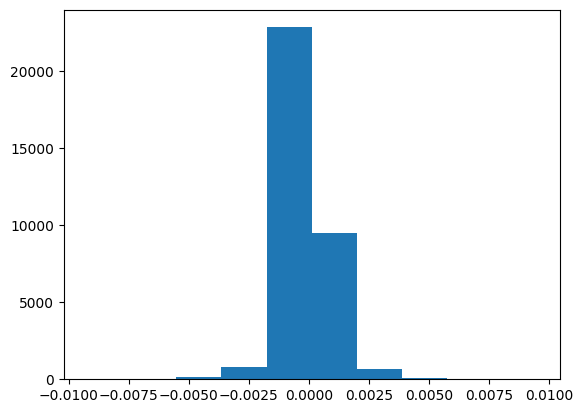

In [97]:
plt.hist(df['zcmb_group'] - df['zcmb'])

In [100]:
# SDSS and LAMOST settings and paths
SDSS_LAMOST_SPECTRO_REQ_COLS = {
    'SDSS': ['objid', 'specObjId', 'RA', 'Dec', 'zhelio', 'zhelioerr', 'SIGMA_STARS', 'SIGMA_STARS_ERR'],
    'LAMOST': ['obsid', 'ra', 'dec', 'z_lamost', 'veldisp', 'veldisp_err']
}
SDSS_LAMOST_SPECTRO_FILEPATH = {
    'SDSS': os.path.join(ROOT_PATH, 'data/raw/sdss/sdss_howlett2022.dat'),
    'LAMOST': os.path.join(ROOT_PATH, 'data/raw/lamost/lamost_DR7_VDcat_20200825.fits')
    }
SDSS_LAMOST_TMASS_FILEPATH = {
    'SDSS': os.path.join(ROOT_PATH, 'data/raw/2mass/sdss_tmass.csv'),
    'LAMOST': os.path.join(ROOT_PATH, 'data/raw/2mass/lamost_tmass.csv')
}
SDSS_LAMOST_OUTPUT_FILEPATH = {
    'SDSS': os.path.join(ROOT_PATH, 'data/preprocessed/spectrophoto/sdss.csv'),
    'LAMOST': os.path.join(ROOT_PATH, 'data/preprocessed/spectrophoto/lamost.csv')
}

JRL_PHOTO_FILEPATH = os.path.join(ROOT_PATH, 'data/raw/r_e_jrl/jhk_r_e.csv')
TEMPEL_GAL_FILEPATH = os.path.join(ROOT_PATH, 'data/external/tempel_group_sdss8/tempel_dr8gal.fits')
TEMPEL_GROUP_FILEPATH = os.path.join(ROOT_PATH, 'data/external/tempel_group_sdss8/tempel_dr8gr.fits')

for survey in ['SDSS']:
    # Open spectroscopy data
    req_cols = SDSS_LAMOST_SPECTRO_REQ_COLS[survey]
    if survey=='SDSS':
        df_spectro = pd.read_csv(SDSS_LAMOST_SPECTRO_FILEPATH[survey], delim_whitespace=True)[req_cols]
    else:
        with fits.open(SDSS_LAMOST_SPECTRO_FILEPATH[survey]) as hdul:
            df_spectro = Table(hdul[1].data).to_pandas()[req_cols]
    print(f'Original number of {survey.upper()} galaxies = {len(df_spectro)}')

    # Open the 2MASS data
    req_cols = ['dist_x', 'ra_01', 'dec_01', 'designation', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
                'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff']
    df_2mass = pd.read_csv(SDSS_LAMOST_TMASS_FILEPATH[survey], low_memory=False)[req_cols]

    # Merge FP + 2MASS and drop measurements without photometry (designation is null)
    print(f"Merging {survey.upper()} spectroscopy with 2MASS photometry...")
    df = df_spectro.merge(df_2mass, left_index=True, right_index=True)
    df = df.dropna(subset='designation').rename({'designation': 'tmass', 'RA': 'ra', 'Dec': 'dec'}, axis=1)
    # Drop rows with duplicated 2MASS Id, pick the one with the smaller dist_x
    df = df.sort_values(by='dist_x', ascending=True)
    df = df.drop_duplicates(subset='tmass')
    # Rename 2MASS id column
    df['tmass'] = '2MASXJ' + df['tmass']
    print(f"Remaining {survey.upper()} galaxies = {len(df)}")

    # Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
    max_delta_ra = np.absolute(max(df['ra'] - df['ra_01']))
    max_delta_dec = np.absolute(max(df['dec'] - df['dec_01']))
    tol_ = 0.001
    print(f'Max delta RA: {max_delta_ra}')
    print(f'Max delta DEC: {max_delta_dec}')

    if (max_delta_ra > tol_) or (max_delta_dec > tol_):
        print('The two tables do not match.')
        raise
    else:
        print(f'The coordinates in {survey.upper()} and 2MASS response are consistent.')
        df = df.drop(['ra_01', 'dec_01'], axis=1)

    # Open John's measurements
    req_cols = ['tmass', 'log_r_h_app_j', 'log_r_h_smodel_j', 'log_r_h_model_j', 'fit_ok_j', 'red_chi_j',
                'log_r_h_app_h', 'log_r_h_smodel_h', 'log_r_h_model_h', 'fit_ok_h',
                'log_r_h_app_k', 'log_r_h_smodel_k', 'log_r_h_model_k', 'fit_ok_k']
    df_jrl = pd.read_csv(JRL_PHOTO_FILEPATH)[req_cols]

    # Merge SDSS_Spectro+2MASS and JRL photometry
    print(f"Merging {survey.upper()}+2MASS with JRL photometry...")
    df = df.merge(df_jrl, on='tmass')
    print(f'Remaining {survey.upper()} galaxies = {len(df)}')

    # Open cluster and group data
    ## Individual galaxies data
    req_cols = ['IDcl', 'RAJ2000', 'DEJ2000']
    with fits.open(TEMPEL_GAL_FILEPATH) as hdul:
        df_gal = Table(hdul[1].data).to_pandas()[req_cols]
    ## Group and cluster data
    req_cols = ['IDcl', 'zcl']
    with fits.open(TEMPEL_GROUP_FILEPATH) as hdul:
        df_gr = Table(hdul[1].data).to_pandas()[req_cols]
    ## Merge the two tables
    df_tempel = df_gal.merge(df_gr, on='IDcl', how='left')

    # Crossmatch SDSS/LAMOST data with Tempel data based on individual galaxy RA and DEC
    coords_mydata = SkyCoord(ra=df['ra'].to_numpy() * u.deg, dec=df['dec'].to_numpy() * u.deg)
    coords_tempel = SkyCoord(ra=df_tempel['RAJ2000'].to_numpy() * u.deg, dec=df_tempel['DEJ2000'].to_numpy() * u.deg)

    idx, sep2d, _ = coords_mydata.match_to_catalog_sky(coords_tempel)
    SEP_THRESH = 2.5
    is_counterpart = sep2d < SEP_THRESH * u.arcsec

    df['tempel_idx'] = idx
    df['tempel_counterpart'] = is_counterpart

    print(f'Joining {survey.upper()} data with Tempel group and cluster data...')
    df = df.merge(df_tempel, left_on='tempel_idx', how='left', right_index=True).drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
    print(f'{survey.upper()} galaxies that are part of a cluster: {len(df[df.tempel_counterpart==True])}')

    # Save the resulting table
    print(f'Number of galaxies = {len(df)}. Number of unique galaxies = {df.tmass.nunique()}. Saving the table to {SDSS_LAMOST_OUTPUT_FILEPATH[survey]}.')
#     df.to_csv(SDSS_LAMOST_OUTPUT_FILEPATH[survey], index=False)

Original number of SDSS galaxies = 34059
Merging SDSS spectroscopy with 2MASS photometry...
Remaining SDSS galaxies = 31631
Max delta RA: 0.0
Max delta DEC: 0.0
The coordinates in SDSS and 2MASS response are consistent.
Merging SDSS+2MASS with JRL photometry...
Remaining SDSS galaxies = 29677
Joining SDSS data with Tempel group and cluster data...
SDSS galaxies that are part of a cluster: 20996
Number of galaxies = 29677. Number of unique galaxies = 29677. Saving the table to /Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/data/preprocessed/spectrophoto/sdss.csv.


In [101]:
df.columns

Index(['objid', 'specObjId', 'ra', 'dec', 'zhelio', 'zhelioerr', 'SIGMA_STARS',
       'SIGMA_STARS_ERR', 'dist_x', 'tmass', 'glon', 'glat', 'j_ba', 'h_ba',
       'k_ba', 'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff',
       'h_r_eff', 'k_r_eff', 'log_r_h_app_j', 'log_r_h_smodel_j',
       'log_r_h_model_j', 'fit_ok_j', 'red_chi_j', 'log_r_h_app_h',
       'log_r_h_smodel_h', 'log_r_h_model_h', 'fit_ok_h', 'log_r_h_app_k',
       'log_r_h_smodel_k', 'log_r_h_model_k', 'fit_ok_k', 'tempel_counterpart',
       'IDcl', 'zcl'],
      dtype='object')

Text(0.5, 0, 'z')

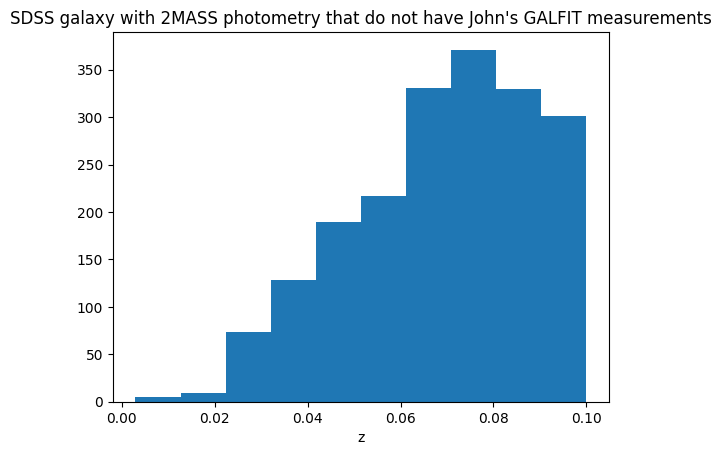

In [90]:
df_join = pd.merge(df, df_jrl, on='tmass', how="outer", indicator=True)
df_left = df_join[df_join._merge == 'left_only']

plt.hist(df_left.zhelio)
plt.title("SDSS galaxy with 2MASS photometry that do not have John's GALFIT measurements")
plt.xlabel('z')

# MERGING LAMOST DATA

In [60]:
# Open spectroscopy data
req_cols = ['obsid', 'ra', 'dec', 'z_lamost', 'veldisp', 'veldisp_err']
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_spectro = Table(hdul[1].data).to_pandas()[req_cols]
print(f'Original number of LAMOST galaxies = {len(df_spectro)}')

# Open the 2MASS data
req_cols = ['ra_01', 'dec_01', 'designation', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
            'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff']
df_2mass = pd.read_csv('data/raw/2mass/lamost_tmass.csv', low_memory=False)[req_cols]

# Merge LAMOST spectro + 2MASS and drop measurements without photometry (designation is null)
print("Merging LAMOST spectroscopy with 2MASS photometry...")
df = df_spectro.merge(df_2mass, left_index=True, right_index=True)
df = df.dropna(subset='designation').rename({'designation': 'tmass'}, axis=1)
df['tmass'] = '2MASXJ' + df['tmass']
print(f"Remaining LAMOST galaxies = {len(df)}")

# Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
max_delta_ra = np.absolute(max(df['ra'] - df['ra_01']))
max_delta_dec = np.absolute(max(df['dec'] - df['dec_01']))
tol_ = 0.001
print(f'Max delta RA: {max_delta_ra}')
print(f'Max delta DEC: {max_delta_dec}')

if (max_delta_ra > tol_) or (max_delta_dec > tol_):
    raise('Error')
else:
    print('The coordinates from the original data and LAMOST are consistent.')
    df = df.drop(['ra_01', 'dec_01'], axis=1)
    
# Open John's measurements
req_cols = ['tmass', 'log_r_h_app_j', 'log_r_h_smodel_j', 'log_r_h_model_j', 'fit_ok_j', 
            'log_r_h_app_h', 'log_r_h_smodel_h', 'log_r_h_model_h', 'fit_ok_h', 
            'log_r_h_app_k', 'log_r_h_smodel_k', 'log_r_h_model_k', 'fit_ok_k']
df_jrl = pd.read_csv('data/raw/r_e_jrl/jhk_r_e.csv')[req_cols]

# Merge LAMOST_Spectro+2MASS and JRL photometry
print("Merging LAMOST+2MASS with JRL photometry...")
df = df.merge(df_jrl, on='tmass')
print(f'Remaining LAMOST galaxies = {len(df)}')

# Open cluster and group data
## Individual galaxies data
req_cols = ['IDcl', 'RAJ2000', 'DEJ2000']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gal.fits') as hdul:
    df_gal = Table(hdul[1].data).to_pandas()[req_cols]
## Group and cluster data
req_cols = ['IDcl', 'zcl']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gr.fits') as hdul:
    df_gr = Table(hdul[1].data).to_pandas()[req_cols]
## Merge the two tables
df_tempel = df_gal.merge(df_gr, on='IDcl', how='left')

# Crossmatch LAMOST data with Tempel data based on individual galaxy RA and DEC
coords_lamost = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)
coords_tempel = SkyCoord(ra=df_tempel['RAJ2000'].to_numpy()*u.deg, dec=df_tempel['DEJ2000'].to_numpy()*u.deg)

idx, sep2d, _ = coords_lamost.match_to_catalog_sky(coords_tempel)
SEP_THRESH = 2.5
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df['tempel_idx'] = idx
df['tempel_counterpart'] = is_counterpart

print(f'Joining LAMOST data with Tempel group and cluster data...')
df = df.merge(df_tempel, left_on='tempel_idx', how='left', right_index=True).drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
print(f'LAMOST galaxies that are part of a cluster: {len(df[df.tempel_counterpart==True])}')

Original number of LAMOST galaxies = 85861
Merging LAMOST spectroscopy with 2MASS photometry...
Remaining LAMOST galaxies = 63969
Max delta RA: 4.000014541816199e-09
Max delta DEC: 0.0
The coordinates from the original data and LAMOST are consistent.
Merging LAMOST+2MASS with JRL photometry...
Remaining LAMOST galaxies = 62997
Joining LAMOST data with Tempel group and cluster data...
LAMOST galaxies that are part of a cluster: 18449


In [61]:
df.tmass.nunique()

62927

In [ ]:
# Compare z_lamost and z_ppxf to SDSS redshift
df_sdss = pd.read_csv('data/raw/sdss/SDSS_spectro.csv')[['ra', 'dec', 'z']]

with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost = Table(hdul[1].data).to_pandas()[['ra', 'dec', 'z_lamost', 'z_ppxf']]

# Sky crossmatch SDSS vs LAMOST
coords_sdss = SkyCoord(ra=df_sdss['ra'].to_numpy()*u.deg, dec=df_sdss['dec'].to_numpy()*u.deg)
coords_lamost = SkyCoord(ra=df_lamost['ra'].to_numpy()*u.deg, dec=df_lamost['dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_lamost.match_to_catalog_sky(coords_sdss)
SEP_THRESH = 1.
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df_lamost['sdss_idx'] = idx
df_lamost['sdss_counterpart'] = is_counterpart

df = df_lamost.merge(df_sdss, left_on='sdss_idx', how='left', right_index=True)#.drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
df = df[df.sdss_counterpart==True]

In [ ]:
df['delta_z_lamost'] = df['z'] - df['z_lamost']
df['delta_z_ppxf'] = df['z'] - df['z_ppxf']

plt.hist(df['delta_z_lamost'], bins=1000)
plt.hist(df['delta_z_ppxf'], bins=1000)

plt.xlim(-0.005, 0.005)
plt.show()

df[['delta_z_lamost', 'delta_z_ppxf']].describe()

In [ ]:
plt.scatter(df.z, df['delta_z_ppxf'], s=1)
plt.scatter(df.z, df['delta_z_lamost'], s=1)
plt.ylim(-0.0006, 0.0006)

In [ ]:
!ls

In [ ]:
df = pd.read_csv('data/preprocessed/spectrophoto/sdss.csv')

In [ ]:
df.columns

# DERIVE $r, s, i$

In [ ]:
# Constants
LIGHTSPEED = 299792.458

# File names
SURVEY_LIST = ['6dFGS', 'SDSS', 'LAMOST']

SURVEY_ID_COL_NAME = {
    'SDSS': 'objID',
    'LAMOST': 'obsid'
}

# A variable to store the aperture sizes and veldisp column names
SPECTROSCOPY_CONFIG = {
    '6dFGS': {
        'aperture_size': 3.35,
        'veldisp_col_name': 'Vd',
        'veldisp_err_col_name': 'e_Vd'
    },
    'SDSS': {
        'aperture_size': 1.5,
        'veldisp_col_name': 'sigmaStars',
        'veldisp_err_col_name': 'sigmaStarsErr'
    },
    'LAMOST': {
        'aperture_size': 1.65,
        'veldisp_col_name': 'veldisp',
        'veldisp_err_col_name': 'veldisp_err'
    }
}

# Galactic extinction constants in the JHK bands
EXTINCTION_CONSTANT = {
    'j': 0.723,
    'h': 0.460,
    'k': 0.310
}

# Sun absolute magnitude constants
SOLAR_MAGNITUDE = {
    'j': 3.67,
    'h': 3.32,
    'k': 3.27
}

for survey in SURVEY_LIST[1:2]:
    '''
    A function to derive r, s, i quantities for each galaxy in the three surveys.
    '''
    # Open spectroscopy+photometry file
    df = pd.read_csv(f'data/preprocessed/spectrophoto/{survey.lower()}.csv')
    print(f'Original number of {survey} galaxies = {len(df)} galaxies.')

    # Extra step only for SDSS and LAMOST
    if survey in ['SDSS', 'LAMOST']:
        
        # Add prefixes to the survey ID's to convert them to object type
        # Only for SDSS and LAMOST as 6dFGS ID's are already object type
        df[SURVEY_ID_COL_NAME[survey]] = survey + df[SURVEY_ID_COL_NAME[survey]].astype(str)
        
        # Select only good J-band radii
        # Selection criteria (from John): fit_OK, r_model > 1 arcsec, reduced chi <= 2.
        df = df[df['fit_ok_j'] == 'OK']
        print(f"Selected galaxies with fit_ok_j == 'OK'. Remaining galaxies = {len(df)}")
        
        df = df[df['log_r_h_model_j'] > 0.]
        print(f"Selected galaxies with log_r_h_model_j > 0. Remaining galaxies = {len(df)}")
        
        df = df[df['red_chi_j'] <= 2.]
        print(f"Selected galaxies with red_chi_j <= 2. Remaining galaxies = {len(df)}")
        
    # ============================================ DERIVING RELEVANT QUANTITIES ====================================#

    # Derive PSF-corrected radii
    print('Deriving PSF-corrected radii...')
    for band in 'jhk':
        if survey == '6dFGS':
            df[f'theta_{band}'] = 10 ** df[f'{band.upper()}logr']
        else:
            df[f'delta_r_{band}'] = 10 ** (df[f'log_r_h_smodel_{band}']) - 10 ** (df[f'log_r_h_model_{band}'])
            df[f'theta_{band}'] = 10 ** (df[f'log_r_h_app_{band}']) - df[f'delta_r_{band}']

    # Calculate CMB frame redshift for individual galaxies (also rederive for 6dFGS)
    from src.utils.helio_cmb import perform_corr
    print('Calculating CMB frame redshift for each galaxy...')
    df['z_cmb'] = perform_corr(df['z'], df['ra'], df['dec'], corrtype='full', dipole='Planck')
    
    # Use group/cluster redshift for galaxies in group/cluster
    print('Obtaining group/cluster mean redshift if available...')
    if survey in ['SDSS', 'LAMOST']:
        df['z_dist_est'] = np.where(df['tempel_counterpart'] == True, df['zcl'], df['z_cmb'])
    else:
        df['z_dist_est'] = np.where(df['cz_gr'] != 0., df['cz_gr'] / LIGHTSPEED, df['z_cmb'])

    # Aperture size corrections for the velocity dispersions
    print('Calculating aperture size-corrected velocity dispersions...')
    # Convert J-band radii to R-band radii
#     R_j = 10 ** (1.029 * np.log10(df['theta_j']) + 0.140)
    R_j = 10 ** (1.029 * np.log10(df['theta_j'] * np.sqrt(df['j_ba'])) + 0.140)
    
    aperture_size = SPECTROSCOPY_CONFIG[survey]['aperture_size']
    veldisp_col = SPECTROSCOPY_CONFIG[survey]['veldisp_col_name']
    veldisp_err_col = SPECTROSCOPY_CONFIG[survey]['veldisp_err_col_name']
    
    df['sigma_corr'] = df[veldisp_col] * ((R_j / 8) / aperture_size) ** (-0.04)
    df['e_sigma_corr'] = df[veldisp_err_col] * ((R_j / 8) / aperture_size) ** (-0.04)
    

    # Calculate Galactic extinctions in the JHK bands
    print('Calculating Galactic extinctions in the JHK band...')
    from dustmaps.sfd import SFDQuery
    from astropy.coordinates import SkyCoord
    from dustmaps.config import config

    config['data_dir'] = 'etc/dustmaps'
    sfd = SFDQuery()
    coords = SkyCoord(df['ra'], df['dec'], unit='deg', frame ='fk5')
    ebv = sfd(coords)
    for band in 'jhk':
        extinction_constant = EXTINCTION_CONSTANT[band]
        df[f'extinction_{band}'] = extinction_constant * ebv


    # Calculate k-corrections
    from src.utils.calc_kcor import calc_kcor
    
    print('Calculating K-corrections...')
    z = df['z'].to_numpy()
    color_J2H2 = (df['j_m_ext'] - df['extinction_j']) - (df['h_m_ext'] - df['extinction_h']).to_numpy()
    color_J2Ks2 = (df['j_m_ext'] - df['extinction_j']) - (df['k_m_ext'] - df['extinction_k']).to_numpy()
    df['kcor_j'] = calc_kcor('J2', z, 'J2 - H2', color_J2H2)
    df['kcor_h'] = calc_kcor('H2', z, 'J2 - H2', color_J2H2)
    df['kcor_k'] = calc_kcor('Ks2', z, 'J2 - Ks2', color_J2Ks2)


    # ============================= DERIVING r, s, i ================================#

    # Derive r and i
    from src.utils.CosmoFunc import rz_table
    from scipy import interpolate
    
    ## Get redshift-distance lookup table
    red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
    ## Comoving distance for individual galaxies
    dz = interpolate.splev(df["z_cmb"].to_numpy(), dist_spline)
    ## Comoving distance for group galaxies
    dz_cluster = interpolate.splev(df["z_dist_est"].to_numpy(), dist_spline)
    ## Use the circularized effective radii
    for band in 'jhk':
        circularized_radius = df[f'theta_{band}'] * np.sqrt(df[f'{band}_ba'])
        df[f'r_{band}'] = np.log10(circularized_radius) + np.log10(dz_cluster) \
                          + np.log10(1000.0 * np.pi / (180.0 * 3600.0)) - np.log10(1.0 + df['z'].to_numpy())
        
        df[f'i_{band}'] = 0.4 * SOLAR_MAGNITUDE[band] - 0.4 * df[f'{band}_m_ext'] - np.log10(2.0 * np.pi) \
                          - 2.0 * np.log10(circularized_radius) + 4.0 * np.log10(1.0 + df['z']) \
                          + 0.4 * df[f'kcor_{band}'] + 0.4 * df[f'extinction_{band}'] \
                          + 2.0 * np.log10(180.0 * 3600.0 / (10.0*np.pi))

    # Derive s
    df['s'] = np.log10(df['sigma_corr'])
    df['es'] = (df['e_sigma_corr'] / df['sigma_corr']) / np.log(10)
    
#     # Remove extreme outliers and zero errors in es (only in SDSS)
#     if file in 'sdss':
#         data = data[data['es']<data['es'].quantile(0.995)]
#         data = data[data['es']>0.]

    # Save the data
#     data.to_csv('../data/FP_observables/1st_step/' + file + '.csv',index=False)

In [ ]:
df_campbell = pd.read_csv(f'data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)[['6dFGSid', 'logsigma', 'elogsigma']]
df_slice = df[['_6dFGS', 's', 'es']]

df_merge = df_campbell.merge(df_slice, left_on='6dFGSid', right_on='_6dFGS')

df_merge['delta_s'] = df_merge['logsigma'] - df_merge['s']
df_merge['delta_es'] = df_merge['elogsigma'] - df_merge['es']

df_merge

In [ ]:
plt.hist(df_merge['delta_s'], bins=100)
plt.title('My s - Campbell s (using circularized radii)')
plt.show()

In [ ]:
df = pd.read_csv('data/preprocessed/spectrophoto/lamost.csv')

df['veldisp_err_frac'] = df['veldisp_err'] / df['veldisp']

df[['veldisp_err_frac']].describe()

# CALIBRATE VELOCITY DISPERSIONS

## Select galaxies with repeat measurements

In [3]:
INPUT_FILEPATH = {
    '6dFGS': 'data/processed/rsi_derived/6dfgs.csv',
    'SDSS': 'data/processed/rsi_derived/sdss.csv',
    'LAMOST': 'data/processed/rsi_derived/lamost.csv'
}

# Grab all of the data and only use their 2MASS and survey ID's
# Also grab the velocity dispersion measurements
data_6df = pd.read_csv(INPUT_FILEPATH['6dFGS'])[['tmass', '_6dFGS', 's', 'es']]
data_6df_id = data_6df[['tmass','_6dFGS']]
data_6df_veldisp = data_6df[['tmass', 's', 'es']].rename(columns={'s':'s_6df','es':'es_6df'})

data_sdss = pd.read_csv(INPUT_FILEPATH['SDSS'])[['tmass', 'objid', 's', 'es']]
data_sdss_id = data_sdss[['tmass','objid']]
data_sdss_veldisp = data_sdss[['tmass', 's', 'es']].rename(columns={'s':'s_sdss','es':'es_sdss'})

data_lamost = pd.read_csv(INPUT_FILEPATH['LAMOST'])[['tmass', 'obsid', 's', 'es']]
data_lamost_id = data_lamost[['tmass','obsid']]
data_lamost_veldisp = data_lamost[['tmass', 's', 'es']].rename(columns={'s':'s_lamost','es':'es_lamost'})

# Find galaxies with repeat measurements for every survey combination
repeat_6df_sdss = pd.merge(data_6df_id, data_sdss_id, on='tmass', how='inner')
repeat_6df_lamost = pd.merge(data_6df_id, data_lamost_id, on='tmass', how='inner')
repeat_sdss_lamost = pd.merge(data_sdss_id, data_lamost_id, on='tmass', how='inner')

# Find galaxies with 3 repeat measurements (observed in all 3 surveys)
repeat_3 = pd.merge(repeat_6df_sdss, repeat_sdss_lamost, on='tmass', how='inner')\
                    .drop('objid_y',axis=1)\
                    .rename(columns={'objid_x':'objid'})

# Find galaxies with 2 repeat measurements
# By removing the repeat 3 galaxies from all of the repeat measurements above
repeat_6df_sdss_only = repeat_6df_sdss[~repeat_6df_sdss['tmass'].isin(repeat_3['tmass'].tolist())]
repeat_6df_lamost_only = repeat_6df_lamost[~repeat_6df_lamost['tmass'].isin(repeat_3['tmass'].tolist())]
repeat_sdss_lamost_only = repeat_sdss_lamost[~repeat_sdss_lamost['tmass'].isin(repeat_3['tmass'].tolist())]

# Create the third survey id name filled with NaN values (so we can concatenate the dataframes later)
repeat_6df_sdss_only.loc[:, ['obsid']] = np.nan
repeat_6df_lamost_only.loc[:, ['objid']] = np.nan
repeat_sdss_lamost_only.loc[:, ['_6dFGS']] = np.nan

# Concatenate the dataframes
df = pd.concat([repeat_3, repeat_6df_sdss_only, repeat_6df_lamost_only, repeat_sdss_lamost_only])

# Grab the velocity dispersion measurements
df = df.merge(data_6df_veldisp, how='left', on='tmass')\
       .merge(data_sdss_veldisp, how='left', on='tmass')\
       .merge(data_lamost_veldisp, how='left', on='tmass')

# Tidying Up the old code

In [6]:
def get_error_scaling_old_method(df_repeat, sigma_clip=5.0, max_iter=10, sdss_first=True):
    '''
    A function to obtain the error scaling
    '''
    def update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, survey, k_sdss=1.0, k_lamost=1.0, sigma_clip=3.0, convergence_tol=0.005):
        '''
        A function to calculate the error scaling for SDSS and LAMOST.
        '''
        print(f'Updating error scaling for {survey}. Number of galaxies used = {len(s_sdss)}')
        # Scale the errors
        es_sdss_scaled = k_sdss * es_sdss
        es_lamost_scaled = k_lamost * es_lamost

        # Calculate the pairwise statistics
        epsilon = (s_sdss - s_lamost) / np.sqrt(es_sdss_scaled**2 + es_lamost_scaled**2)

        # Apply sigma clipping before calculating the new error scaling
        print(f'Applying {sigma_clip} sigma clipping...')
        sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
        es_sdss_clipped = es_sdss_scaled[sigma_clip_filter]
        es_lamost_clipped = es_lamost_scaled[sigma_clip_filter]
        epsilon_clipped = epsilon[sigma_clip_filter]
        print(f'Number of comparisons remaining = {len(epsilon_clipped)}.')

        # Update the error scaling and check convergence
        N = len(epsilon_clipped)
        rms_sdss = (1 / N) * np.sum(es_sdss_clipped**2)
        rms_lamost = (1 / N) * np.sum(es_lamost_clipped**2)
        f2 = np.std(epsilon_clipped)**2

        if survey == 'SDSS':
            k_new = np.sqrt(f2 + (f2 - 1) * (rms_lamost / rms_sdss))
            k_updated = k_sdss * k_new
            is_convergent = np.absolute((k_updated - k_sdss) / k_updated) * 100 < convergence_tol
        elif survey == 'LAMOST':
            k_new = np.sqrt(f2 + (f2 - 1) * (rms_sdss / rms_lamost))
            k_updated = k_lamost * k_new
            is_convergent = np.absolute((k_updated - k_lamost) / k_updated) * 100 < convergence_tol

        print(f'New scaling for {survey} = {k_updated}.')
        return k_updated, is_convergent

    # SDSS and LAMOST veldisp
    s_sdss = df_repeat['s_sdss'].to_numpy()
    es_sdss = df_repeat['es_sdss'].to_numpy()
    s_lamost = df_repeat['s_lamost'].to_numpy()
    es_lamost = df_repeat['es_lamost'].to_numpy()
    
    # Initial scalings for SDSS and LAMOST
    k_sdss = 1.0
    k_lamost = 1.0
    
    # Find the error scalings
    for i in range(max_iter):
        if sdss_first:
            # Update SDSS error
            k_sdss, is_sdss_convergent = update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, 'SDSS', k_sdss, k_lamost, sigma_clip)
            # Update LAMOST error
            k_lamost, is_lamost_convergent = update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, 'LAMOST', k_sdss, k_lamost, sigma_clip)
        else:
            # Update LAMOST error
            k_lamost, is_lamost_convergent = update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, 'LAMOST', k_sdss, k_lamost, sigma_clip)
            # Update SDSS error
            k_sdss, is_sdss_convergent = update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, 'SDSS', k_sdss, k_lamost, sigma_clip)

        print(f'Iteration {i}. SDSS scaling = {round(k_sdss, 3)}. LAMOST scaling = {round(k_lamost, 3)}')
        
        if (is_lamost_convergent) and (is_sdss_convergent):
            print('Convergence is reached for both error scalings.')
            break
    else:
        print('Maximum number of iterations reached')
        
    return k_sdss, k_lamost
    
k_sdss, k_lamost = get_error_scaling_old_method(df, sigma_clip=3.5, sdss_first=True)
print(f"{'='*50}")
print(f'Final SDSS scaling = {round(k_sdss, 3)}')
print(f'Final LAMOST scaling = {round(k_lamost, 3)}')

Updating error scaling for SDSS. Number of galaxies used = 6452
Applying 3.5 sigma clipping...
Number of comparisons remaining = 5788.
New scaling for SDSS = 2.5876518997008344.
Updating error scaling for LAMOST. Number of galaxies used = 6452
Applying 3.5 sigma clipping...
Number of comparisons remaining = 6352.
New scaling for LAMOST = 1.7507529959601817.
Iteration 0. SDSS scaling = 2.588. LAMOST scaling = 1.751
Updating error scaling for SDSS. Number of galaxies used = 6452
Applying 3.5 sigma clipping...
Number of comparisons remaining = 6427.
New scaling for SDSS = 2.7593505573738857.
Updating error scaling for LAMOST. Number of galaxies used = 6452
Applying 3.5 sigma clipping...
Number of comparisons remaining = 6427.
New scaling for LAMOST = 1.7507662442145029.
Iteration 1. SDSS scaling = 2.759. LAMOST scaling = 1.751
Updating error scaling for SDSS. Number of galaxies used = 6452
Applying 3.5 sigma clipping...
Number of comparisons remaining = 6427.
New scaling for SDSS = 2.7593

# Use 6dFGS as the fiducial

In [11]:
def get_error_scaling_6df_fiducial(df_repeat, sigma_clip=5.0, max_iter=10):
    '''
    A function to obtain the error scaling
    '''
    def update_error_scaling(s_var, es_var, s_6df, es_6df, survey, k=1.0, sigma_clip=3.0, convergence_tol=0.005):
        '''
        A function to calculate the error scaling for SDSS and LAMOST.
        '''
        print(f'Updating error scaling for {survey}. Number of galaxies used = {len(s_sdss)}')
        # Scale the errors
        es_var_scaled = k * es_var

        # Calculate the pairwise statistics
        epsilon = (s_var - s_6df) / np.sqrt(es_var_scaled**2 + es_6df**2)

        # Apply sigma clipping before calculating the new error scaling
        print(f'Applying {sigma_clip} sigma clipping...')
        sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
        es_var_clipped = es_var_scaled[sigma_clip_filter]
        es_6df_clipped = es_6df[sigma_clip_filter]
        epsilon_clipped = epsilon[sigma_clip_filter]
        print(f'Number of comparisons remaining = {len(epsilon_clipped)}.')

        # Update the error scaling and check convergence
        N = len(epsilon_clipped)
        rms_var = (1 / N) * np.sum(es_var_clipped**2)
        rms_6df = (1 / N) * np.sum(es_6df_clipped**2)
        f2 = np.std(epsilon_clipped)**2
        k_new = np.sqrt(f2 + (f2 - 1) * (rms_var / rms_6df))
        k_updated = k * k_new
        is_convergent = np.absolute((k_updated - k) / k_updated) * 100 < convergence_tol

        print(f'New scaling for {survey} = {k_updated}.')
        return k_updated, is_convergent

    # SDSS and LAMOST veldisp
    df_calib = df_repeat
    s_6df = df_calib['s_6df'].to_numpy()
    es_6df = df_calib['es_6df'].to_numpy()
    s_sdss = df_calib['s_sdss'].to_numpy()
    es_sdss = df_calib['es_sdss'].to_numpy()
    s_lamost = df_calib['s_lamost'].to_numpy()
    es_lamost = df_calib['es_lamost'].to_numpy()
    
    # Initial scalings for SDSS and LAMOST
    k_sdss = 1.0
    k_lamost = 1.0
    
    # Find the error scalings
    for i in range(max_iter):
        # Update LAMOST error
        k_lamost, is_lamost_convergent = update_error_scaling(s_lamost, es_lamost, s_6df, es_6df, 'LAMOST', k_lamost, sigma_clip)
        
        # Update SDSS error
        k_sdss, is_sdss_convergent = update_error_scaling(s_sdss, es_sdss, s_6df, es_6df, 'SDSS', k_sdss, sigma_clip)

        print(f'Iteration {i}. SDSS scaling = {round(k_sdss, 3)}. LAMOST scaling = {round(k_lamost, 3)}')
        
        if (is_lamost_convergent) and (is_sdss_convergent):
            print('Convergence is reached for both error scalings.')
            break
    else:
        print('Maximum number of iterations reached')
        
    return k_sdss, k_lamost
    
k_sdss, k_lamost = get_error_scaling_6df_fiducial(df, sigma_clip=3.5)
print(f"{'='*50}")
print(f'Final SDSS scaling = {round(k_sdss, 3)}')
print(f'Final LAMOST scaling = {round(k_lamost, 3)}')

Updating error scaling for LAMOST. Number of galaxies used = 6554
Applying 3.5 sigma clipping...
Number of comparisons remaining = 68.
New scaling for LAMOST = 1.5104756117906182.
Updating error scaling for SDSS. Number of galaxies used = 6554
Applying 3.5 sigma clipping...
Number of comparisons remaining = 45.
New scaling for SDSS = 0.7168303248362541.
Iteration 0. SDSS scaling = 0.717. LAMOST scaling = 1.51
Updating error scaling for LAMOST. Number of galaxies used = 6554
Applying 3.5 sigma clipping...
Number of comparisons remaining = 68.
New scaling for LAMOST = 2.167845895437296.
Updating error scaling for SDSS. Number of galaxies used = 6554
Applying 3.5 sigma clipping...
Number of comparisons remaining = 45.
New scaling for SDSS = 0.5227133814409082.
Iteration 1. SDSS scaling = 0.523. LAMOST scaling = 2.168
Updating error scaling for LAMOST. Number of galaxies used = 6554
Applying 3.5 sigma clipping...
Number of comparisons remaining = 68.
New scaling for LAMOST = 2.889230385596

# Use SDSS as the fiducial

In [42]:
def get_error_scaling_one_fiducial(df_repeat, sigma_clip=5.0, max_iter=10):
    '''
    A function to obtain the error scaling
    '''
    def update_error_scaling(s_var, es_var, s_fiducial, es_fiducial, survey, k=1.0, sigma_clip=3.0, convergence_tol=0.005):
        '''
        A function to calculate the error scaling for SDSS and LAMOST.
        '''
        try:
            print(f'Updating error scaling for {survey}. Number of galaxies used = {len(s_sdss)}')
            # Scale the errors
            es_var_scaled = k * es_var

            # Calculate the pairwise statistics
            epsilon = (s_var - s_fiducial) / np.sqrt(es_var_scaled**2 + es_fiducial**2)

            # Apply sigma clipping before calculating the new error scaling
            print(f'Applying {sigma_clip} sigma clipping...')
            sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
            es_var_clipped = es_var_scaled[sigma_clip_filter]
            es_fiducial_clipped = es_fiducial[sigma_clip_filter]
            epsilon_clipped = epsilon[sigma_clip_filter]
            print(f'Number of comparisons remaining = {len(epsilon_clipped)}.')

            # Update the error scaling and check convergence
            N = len(epsilon_clipped)
            rms_var = (1 / N) * np.sum(es_var_clipped**2)
            rms_fiducial = (1 / N) * np.sum(es_fiducial_clipped**2)
            f2 = np.std(epsilon_clipped)**2
            k_new = np.sqrt(f2 + (f2 - 1) * (rms_fiducial / rms_var))
            k_updated = k * k_new
            is_convergent = np.absolute((k_updated - k) / k_updated) * 100 < convergence_tol

            print(f'New scaling for {survey} = {k_updated}.')
            return k_updated, is_convergent
        except Exception as e:
            print(f'Finding scaling for {survey} failed. Reason: {e}')
            return k, True

    # SDSS and LAMOST veldisp
    df_calib = df_repeat
    s_6df = df_calib['s_6df'].to_numpy()
    es_6df = df_calib['es_6df'].to_numpy()
    s_sdss = df_calib['s_sdss'].to_numpy()
    es_sdss = df_calib['es_sdss'].to_numpy()
    s_lamost = df_calib['s_lamost'].to_numpy()
    es_lamost = df_calib['es_lamost'].to_numpy()
    
    # Initial scalings for SDSS and LAMOST
    k_6df = 1.0
    k_lamost = 1.0
    
    # Find the error scalings
    for i in range(max_iter):
        # Update LAMOST error 
        k_lamost, is_lamost_convergent = update_error_scaling(s_lamost, es_lamost, s_sdss, es_sdss, 'LAMOST', k_lamost, sigma_clip)
        
#         Update 6dFGS error
        k_6df, is_6df_convergent = update_error_scaling(s_6df, es_6df, s_sdss, es_sdss, '6dFGS', k_sdss, sigma_clip)

        print(f'Iteration {i}. 6dFGS scaling = {round(k_6df, 3)}. LAMOST scaling = {round(k_lamost, 3)}')
        
        if (is_lamost_convergent) and (is_6df_convergent):
            print('Convergence is reached for both error scalings.')
            break
    else:
        print('Maximum number of iterations reached')
        
    return k_6df, k_lamost
    
k_6df, k_lamost = get_error_scaling_one_fiducial(df, sigma_clip=5.0)
print(f"{'='*50}")
print(f'Final 6dFGS scaling = {round(k_6df, 3)}')
print(f'Final LAMOST scaling = {round(k_lamost, 3)}')

Updating error scaling for LAMOST. Number of galaxies used = 6554
Applying 5.0 sigma clipping...
Number of comparisons remaining = 6280.
New scaling for LAMOST = 2.2732076359870814.
Updating error scaling for 6dFGS. Number of galaxies used = 6554
Applying 5.0 sigma clipping...
Number of comparisons remaining = 28.
New scaling for 6dFGS = 0.4046391996737848.
Iteration 0. 6dFGS scaling = 0.405. LAMOST scaling = 2.273
Updating error scaling for LAMOST. Number of galaxies used = 6554
Applying 5.0 sigma clipping...
Number of comparisons remaining = 6445.
New scaling for LAMOST = 2.6698109042063507.
Updating error scaling for 6dFGS. Number of galaxies used = 6554
Applying 5.0 sigma clipping...
Number of comparisons remaining = 28.
New scaling for 6dFGS = 0.4046391996737848.
Iteration 1. 6dFGS scaling = 0.405. LAMOST scaling = 2.67
Updating error scaling for LAMOST. Number of galaxies used = 6554
Applying 5.0 sigma clipping...
Number of comparisons remaining = 6448.
New scaling for LAMOST = 2

# Only Scale LAMOST errors

In [39]:
def get_error_scaling_lamost_only(df_repeat, sigma_clip=5.0, max_iter=10):
    '''
    A function to obtain the error scaling
    '''
    def update_error_scaling(s_var, es_var, s_fiducial, es_fiducial, survey, k=1.0, sigma_clip=3.0, convergence_tol=0.005):
        '''
        A function to calculate the error scaling for SDSS and LAMOST.
        '''
        try:
            print(f'Updating error scaling for LAMOST using {survey} as the fiducial.')
            # Scale the errors
            es_var_scaled = k * es_var

            # Calculate the pairwise statistics
            epsilon = (s_var - s_fiducial) / np.sqrt(es_var_scaled**2 + es_fiducial**2)

            # Apply sigma clipping before calculating the new error scaling
            print(f'Applying {sigma_clip} sigma clipping...')
            sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
            es_var_clipped = es_var_scaled[sigma_clip_filter]
            es_fiducial_clipped = es_fiducial[sigma_clip_filter]
            epsilon_clipped = epsilon[sigma_clip_filter]
            print(f'Number of comparisons remaining = {len(epsilon_clipped)}.')

            # Update the error scaling and check convergence
            N = len(epsilon_clipped)
            rms_var = (1 / N) * np.sum(es_var_clipped**2)
            rms_fiducial = (1 / N) * np.sum(es_fiducial_clipped**2)
            f2 = np.std(epsilon_clipped)**2
            k_new = np.sqrt(f2 + (f2 - 1) * (rms_fiducial / rms_var))
            k_updated = k * k_new
            is_convergent = np.absolute((k_updated - k) / k_updated) * 100 < convergence_tol

            print(f'New scaling for LAMOST using {survey} fiducial = {k_updated}.')
            return k_updated, is_convergent
        except Exception as e:
            print(f'Finding scaling for LAMOST using {survey} fiducial failed. Reason: {e}')
            return k, True

    # SDSS and LAMOST veldisp
    s_6df = df_repeat['s_6df'].to_numpy()
    es_6df = df_repeat['es_6df'].to_numpy()
    s_sdss = df_repeat['s_sdss'].to_numpy()
    es_sdss = df_repeat['es_sdss'].to_numpy()
    s_lamost = df_repeat['s_lamost'].to_numpy()
    es_lamost = df_repeat['es_lamost'].to_numpy()
    
    # Initial scalings for SDSS and LAMOST
    k_lamost_sdss_fid = 1.0
    k_lamost_6df_fid = 1.0
    
    # Find the error scalings
    for i in range(max_iter):
        # Using SDSS fiducial 
        k_lamost_sdss_fid, is_lamost_sdss_fid_convergent = update_error_scaling(s_lamost, es_lamost, s_sdss, es_sdss, 'SDSS', k_lamost_sdss_fid, sigma_clip)
        
        # Using 6dFGS fiducial
        k_lamost_6df_fid, is_lamost_6df_fid_convergent = update_error_scaling(s_lamost, es_lamost, s_6df, es_6df, '6dFGS', k_lamost_6df_fid, sigma_clip)

        print(f'Iteration {i}. LAMOST scaling using SDSS fiducial = {round(k_lamost_sdss_fid, 3)}. LAMOST scaling using 6dFGS fiducial = {round(k_lamost_6df_fid, 3)}')
        
        if (is_lamost_sdss_fid_convergent) and (is_lamost_6df_fid_convergent):
            print('Convergence is reached for both error scalings.')
            break
    else:
        print('Maximum number of iterations reached')
        
    return k_lamost_sdss_fid, k_lamost_6df_fid
    
k_lamost_sdss_fid, k_lamost_6df_fid = get_error_scaling_lamost_only(df, sigma_clip=3.5)
print(f"{'='*50}")
print(f'Final LAMOST scaling using SDSS as fiducial = {round(k_lamost_sdss_fid, 3)}')
print(f'Final LAMOST scaling using 6dFGS as fiducial = {round(k_lamost_6df_fid, 3)}')

Updating error scaling for LAMOST using SDSS as the fiducial.
Applying 3.5 sigma clipping...
Number of comparisons remaining = 5788.
New scaling for LAMOST using SDSS fiducial = 1.8974807420710964.
Updating error scaling for LAMOST using 6dFGS as the fiducial.
Applying 3.5 sigma clipping...
Number of comparisons remaining = 68.
New scaling for LAMOST using 6dFGS fiducial = 3.5373497226293984.
Iteration 0. LAMOST scaling using SDSS fiducial = 1.897. LAMOST scaling using 6dFGS fiducial = 3.537
Updating error scaling for LAMOST using SDSS as the fiducial.
Applying 3.5 sigma clipping...
Number of comparisons remaining = 6348.
New scaling for LAMOST using SDSS fiducial = 2.446040138341451.
Updating error scaling for LAMOST using 6dFGS as the fiducial.
Applying 3.5 sigma clipping...
Number of comparisons remaining = 69.
New scaling for LAMOST using 6dFGS fiducial = 4.0712009202155395.
Iteration 1. LAMOST scaling using SDSS fiducial = 2.446. LAMOST scaling using 6dFGS fiducial = 4.071
Updatin

In [25]:
s_6df = df['s_6df'].to_numpy()
es_6df = df['es_6df'].to_numpy()
s_sdss = df['s_sdss'].to_numpy()
es_sdss = df['es_sdss'].to_numpy()
s_lamost = df['s_lamost'].to_numpy()
es_lamost = df['es_lamost'].to_numpy()

sigma_clip = 100.
k_lamost = 1.0

es_lamost_scaled = k_lamost * es_lamost

epsilon = (s_sdss - s_lamost) / np.sqrt(es_sdss**2 + es_lamost_scaled**2)

print(f'Applying {sigma_clip} sigma clipping...')
sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
es_sdss_clipped = es_sdss[sigma_clip_filter]
es_lamost_clipped = es_lamost_scaled[sigma_clip_filter]
epsilon_clipped = epsilon[sigma_clip_filter]
print(f'Number of comparisons remaining = {len(epsilon_clipped)}.')

N = len(epsilon_clipped)
f2 = np.std(epsilon_clipped)**2
rms_sdss = (1 / N) * np.sum(es_sdss_clipped**2)
rms_lamost = (1 / N) * np.sum(es_lamost_clipped**2)
k_new = np.sqrt(f2 + (f2 - 1) * (rms_sdss / rms_lamost))

k_new


Applying 100.0 sigma clipping...
Number of comparisons remaining = 6452.


2.5735628284736336

In [30]:
s_6df = df['s_6df'].to_numpy()
es_6df = df['es_6df'].to_numpy()
s_sdss = df['s_sdss'].to_numpy()
es_sdss = df['es_sdss'].to_numpy()
s_lamost = df['s_lamost'].to_numpy()
es_lamost = df['es_lamost'].to_numpy()

sigma_clip = 100.
k_lamost = 2.5735628284736336 * 1.0603350954681061 * 1.0027579822299473 * 1.0001250751581687 * 1.0000056699317101

es_lamost_scaled = k_lamost * es_lamost

epsilon = (s_sdss - s_lamost) / np.sqrt(es_sdss**2 + es_lamost_scaled**2)

print(f'Applying {sigma_clip} sigma clipping...')
sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
es_sdss_clipped = es_sdss[sigma_clip_filter]
es_lamost_clipped = es_lamost_scaled[sigma_clip_filter]
epsilon_clipped = epsilon[sigma_clip_filter]
print(f'Number of comparisons remaining = {len(epsilon_clipped)}.')

N = len(epsilon_clipped)
f2 = np.std(epsilon_clipped)**2
rms_sdss = (1 / N) * np.sum(es_sdss_clipped**2)
rms_lamost = (1 / N) * np.sum(es_lamost_clipped**2)
k_new = np.sqrt(f2 + (f2 - 1) * (rms_sdss / rms_lamost))

k_new

Applying 100.0 sigma clipping...
Number of comparisons remaining = 6452.


1.0000002570258033

In [31]:
k_lamost

2.7367228450969154

## First approach: only scale LAMOST errors

In [122]:
# Sigma clipping threshold
sigma_clip = 3.0

# Initial scaling for LAMOST
k_lamost = 1.0

# Number of maximum iteration
Nmax = 20

# Reject measurements that are too different
offset_threshold = 1000.

def update_error_scaling(s_6df, es_6df, s_sdss, es_sdss, s_lamost, es_lamost, survey, k_6df=1.0, k_sdss=1.0, k_lamost=1.0, sigma_clip=3.0, convergence_tol=0.05):

    # Scale the errors
    es_lamost_scaled = k_lamost * es_lamost
    
    if survey == 'SDSS':
        # Calculate the pairwise statistics (compare with SDSS)
        epsilon = (s_sdss - s_lamost) / np.sqrt(es_sdss**2 + es_lamost_scaled**2)
        
        # Apply sigma clipping before calculating the new error scaling
        sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
        es_sdss_clipped = es_sdss[sigma_clip_filter]
        es_lamost_clipped = es_lamost_scaled[sigma_clip_filter]
        epsilon_clipped = epsilon[sigma_clip_filter]
        
        # Update the error scaling and check convergence
        N = len(epsilon_clipped)
        rms_sdss = (1 / N) * np.sum(es_sdss_clipped**2)
        rms_lamost = (1 / N) * np.sum(es_lamost_clipped**2)
        epsilon_var = np.std(epsilon_clipped)**2
        
        k_new = np.sqrt(epsilon_var + (epsilon_var - 1) * (rms_sdss / rms_lamost))
        k_updated = k_lamost * k_new
        is_convergent = np.absolute((k_updated - k_lamost) / k_updated) * 100 < convergence_tol
    elif survey == '6dFGS':
        # Calculate the pairwise statistics (compare with 6dFGS)
        epsilon = (s_6df - s_lamost) / np.sqrt(es_6df**2 + es_lamost_scaled**2)
        
        # Apply sigma clipping before calculating the new error scaling
        sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
        es_6df_clipped = es_6df[sigma_clip_filter]
        es_lamost_clipped = es_lamost_scaled[sigma_clip_filter]
        epsilon_clipped = epsilon[sigma_clip_filter]
        
        # Update the error scaling and check convergence
        N = len(epsilon_clipped)
        rms_6df = (1 / N) * np.sum(es_6df_clipped**2)
        rms_lamost = (1 / N) * np.sum(es_lamost_clipped**2)
        epsilon_var = np.std(epsilon_clipped)**2
        
        k_new = np.sqrt(epsilon_var + (epsilon_var - 1) * (rms_6df / rms_lamost))
        k_updated = k_lamost * k_new
        is_convergent = np.absolute((k_updated - k_lamost) / k_updated) * 100 < convergence_tol
    
    return k_updated, is_convergent
    
# SDSS and LAMOST veldisp
df_calib = df[(df['objid'].notna()) 
                & (df['obsid'].notna()) 
                & (np.absolute(df['s_sdss'] - df['s_lamost']) < offset_threshold)]

# Original data
s_6df = df_calib['s_6df'].to_numpy()
es_6df = df_calib['es_6df'].to_numpy()
s_sdss = df_calib['s_sdss'].to_numpy()
es_sdss = df_calib['es_sdss'].to_numpy()
s_lamost = df_calib['s_lamost'].to_numpy()
es_lamost = df_calib['es_lamost'].to_numpy()    

# Iterate using SDSS as comparison
for i in range(Nmax):
    # Update LAMOST error
    k_lamost, converged = update_error_scaling(s_6df, es_6df, s_sdss, es_sdss, s_lamost, es_lamost, 'SDSS', k_lamost=k_lamost, sigma_clip=sigma_clip)
    
    print(f'Iteration {i}. LAMOST scaling = {round(k_lamost, 3)}')
    
    if converged:
        print('Convergence is reached.')
        break
else:
    print('Maximum iteration is reached.')
print('Final LAMOST scaling (comparing with SDSS) = %.3f' % k_lamost)

k_lamost = 1.0
# Iterate using 6dFGS as comparison
for i in range(Nmax):
    # Update LAMOST error
    k_lamost, converged = update_error_scaling(s_6df, es_6df, s_sdss, es_sdss, s_lamost, es_lamost, '6dFGS', k_lamost=k_lamost, sigma_clip=sigma_clip)
    
    print(f'Iteration {i}. LAMOST scaling = {round(k_lamost, 3)}')
    
    if converged:
        print('Convergence is reached.')
        break
else:
    print('Maximum iteration is reached.')
print('Final LAMOST scaling (comparing with 6dFGS) = %.3f' % k_lamost)

Iteration 0. LAMOST scaling = 1.677
Iteration 1. LAMOST scaling = 2.245
Iteration 2. LAMOST scaling = 2.512
Iteration 3. LAMOST scaling = 2.567
Iteration 4. LAMOST scaling = 2.587
Iteration 5. LAMOST scaling = 2.592
Iteration 6. LAMOST scaling = 2.593
Convergence is reached.
Final LAMOST scaling (comparing with SDSS) = 2.593
Iteration 0. LAMOST scaling = 0.25
Iteration 1. LAMOST scaling = 0.43
Iteration 2. LAMOST scaling = 0.404
Iteration 3. LAMOST scaling = 0.409
Iteration 4. LAMOST scaling = 0.408
Iteration 5. LAMOST scaling = 0.408
Convergence is reached.
Final LAMOST scaling (comparing with 6dFGS) = 0.408


In [124]:
# Set random seed
np.random.seed(42)

# Error scalings
k_sdss = 1.0
k_lamost = 2.593

# Open the repeat measurements file
df = pd.read_csv('data/processed/veldisp_calibrated/repeat_ori.csv')
# Apply the error scalings
df['es_sdss'] = df['es_sdss'] * k_sdss
df['es_lamost'] = df['es_lamost'] * k_lamost

# Initial sigmas and error of sigmas
isig = df[['s_6df', 's_sdss', 's_lamost']].to_numpy()
idsig = df[['es_6df', 'es_sdss', 'es_lamost']].to_numpy()

SURVEY_LIST = ['6dFGS', 'SDSS', 'LAMOST']

N = isig.shape[0]  # Number of galaxies
cut = 0.2         # Offset clipping
target = 0.5      # Offset significance target is less than this
nboot = 10        # Number of bootstrap samples (Monte Carlo simulations)
runs = 3          # 3 surveys in total
apply = 0
max_iter = 100

totoffs = []

# Iterate for every bootstrap instance (simulated sigmas)
for boot in range(nboot):
    # For the first simulation, use the measurements directly
    if (boot == 0):
        ssig = isig
        dsig = idsig
    # Else, use Monte Carlo sample
    else:
        ssig = isig + idsig * np.random.normal(size=idsig.shape)
        dsig = idsig
    
    # Reset the total offset at the beginning of each simulation
    totoff = np.zeros(runs)  # Total offset (scaled to whichever survey picked)
    iteration = 0
    maxrat = 999
    
    levels = np.zeros(shape=(max_iter, 3))
    while ((maxrat >= target) and (iteration < max_iter)):
        iteration += 1
        print(f'================== Simulation {boot}. Iteration {iteration}. Offsets = {totoff} ==================')

        # Apply the offset at the beginning of each iteration (why?)
        sig = ssig - totoff
        # Set maximum significance as 0
        maxrat = 0
        # Number of surveys with significant offset (set as 0)
        nbig = 0
        
        # Calculate the offset for each survey
        for j, survey in enumerate(SURVEY_LIST):
            off = np.zeros(runs)
            err = np.zeros(runs)
            norms = np.zeros(runs)
            rat = np.zeros(runs)
            
            # Find the list of galaxies with measurements in the target survey
            target_survey_index = ~np.isnan(sig[:, j])
            print(f'Number of galaxies in {survey} = {len(target_survey_index)}.')
            
            # Calculate for each galaxy
            sig_over_dsig = sig / (dsig**2)
            one_over_dsig = 1 / (dsig**2)
            count_notnan = (~np.isnan(sig)).astype(int)
            
            # Target survey quantities
            x = sig_over_dsig[target_survey_index, j]
            dx = one_over_dsig[target_survey_index, j]
            m = count_notnan[target_survey_index, j]
            
            # Other surveys quantities
            y = np.nansum(np.delete(sig_over_dsig, j, axis=1), axis=1)[target_survey_index]
            dy = np.nansum(np.delete(one_over_dsig, j, axis=1), axis=1)[target_survey_index]
            n = np.nansum(np.delete(count_notnan, j, axis=1), axis=1)[target_survey_index]

            # Calculate for each galaxy again
            wt = m * n
            x = x / dx
            dx = np.sqrt(1 / dx)
            y = y / dy
            dy = np.sqrt(1 / dy)
            diff = x - y
            
            # Filter galaxies where diff > cut
            offset_cut_filter = np.absolute(diff) < cut
            off[j] = np.sum((wt * diff)[offset_cut_filter])
            err[j] = np.sum((wt**2 * (dx**2 + dy**2))[offset_cut_filter])
            norms[j] = np.sum(wt[offset_cut_filter])
            
            # Determine the offset
            off[j] = off[j] / norms[j]
            err[j] = np.sqrt(err[j]) / norms[j]
            rat[j] = off[j] / err[j]
            levels[iteration, j] = rat[j]
            print(f'Survey = {survey}. N = {int(norms[j])}. Offset = {round(off[j], 3)}. Error = {round(err[j], 3)}. Level = {round(rat[j], 3)}.')

            absrat = np.absolute(rat[j])
            if absrat > maxrat:
                maxrat = absrat
            if absrat >= target:
                nbig += 1
            level = apply
            if absrat >= level:
                totoff[j] = totoff[j] + off[j]
        print(totoff)
        print(f"There are {nbig} significant surveys.")
    totoffs.append(totoff - totoff[1])
    
# totoff = totoff - totoff[1]
# print('\n')
# print('SDSS offset = %.3f' % totoff[0] + r' +- %.3f' % err[0])
# print('6dFGS offset = %.3f' % totoff[1] + r' +- %.3f' % err[1])
# print('LAMOST offset = %.3f' % totoff[2] + r' +- %.3f' % err[2])

================== Simulation 0. Iteration 1. Offsets = [0. 0. 0.] ==================
Number of galaxies in 6dFGS = 21771.
Survey = 6dFGS. N = 421. Offset = -0.026. Error = 0.004. Level = -6.938.
Number of galaxies in SDSS = 21771.
Survey = SDSS. N = 20655. Offset = -0.003. Error = 0.001. Level = -4.106.
Number of galaxies in LAMOST = 21771.
Survey = LAMOST. N = 20414. Offset = 0.003. Error = 0.001. Level = 4.803.
[-0.02570018 -0.00260991  0.00308155]
There are 3 significant surveys.
================== Simulation 0. Iteration 2. Offsets = [-0.02570018 -0.00260991  0.00308155] ==================
Number of galaxies in 6dFGS = 21771.
Survey = 6dFGS. N = 421. Offset = -0.003. Error = 0.004. Level = -0.707.
Number of galaxies in SDSS = 21771.
Survey = SDSS. N = 20683. Offset = 0.002. Error = 0.001. Level = 2.961.
Number of galaxies in LAMOST = 21771.
Survey = LAMOST. N = 20444. Offset = -0.002. Error = 0.001. Level = -2.963.
[-0.02835007 -0.00072724  0.00118023]
There are 3 significant surv

In [125]:
totoffs

[array([-0.02628138,  0.        ,  0.00328945]),
 array([-0.02233155,  0.        ,  0.00520939]),
 array([-0.02171773,  0.        ,  0.00465912]),
 array([-0.02255485,  0.        ,  0.00416532]),
 array([-0.01963067,  0.        ,  0.00361177]),
 array([-0.02510063,  0.        ,  0.00500012]),
 array([-0.02850008,  0.        ,  0.00421148]),
 array([-0.01940961,  0.        ,  0.00396918]),
 array([-0.01882531,  0.        ,  0.00461936]),
 array([-0.0222252 ,  0.        ,  0.00443018])]

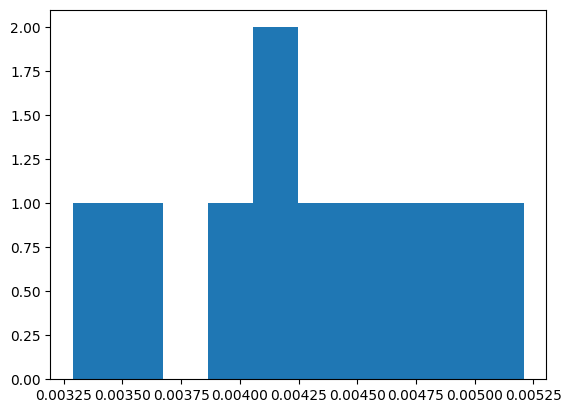

In [126]:
totoffs = np.array(totoffs)
plt.hist(totoffs[:, 2])
plt.show()

In [420]:
totoffs.s

[array([-0.02538528,  0.        ,  0.00378462]),
 array([-0.02025174,  0.        ,  0.0019447 ]),
 array([-0.02548598,  0.        ,  0.0004354 ]),
 array([-0.0240694 ,  0.        ,  0.00141747]),
 array([-0.01997117,  0.        ,  0.00026605]),
 array([-0.02444884,  0.        ,  0.00151188]),
 array([-0.0290767 ,  0.        ,  0.00070419]),
 array([-0.0217442 ,  0.        ,  0.00065482]),
 array([-0.02147706,  0.        ,  0.00087625]),
 array([-0.02460344,  0.        ,  0.00094113])]

Text(0.5, 0, 'iteration')

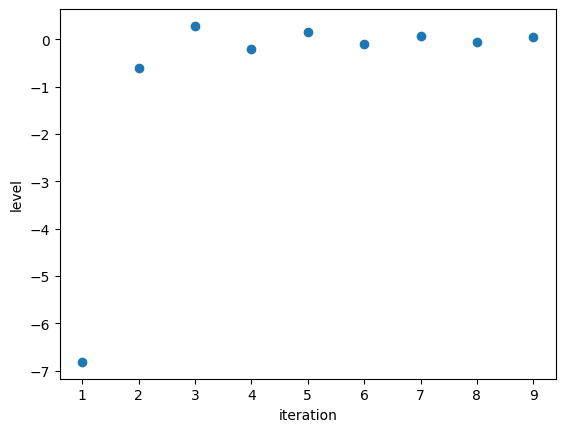

In [410]:
x = levels[:, 0]
x = x[x != 0]

plt.scatter(list(range(1, len(x) + 1)), x)
plt.ylabel('level')
plt.xlabel('iteration')

=============================SDSS vs 6dFGS=============================
Mean of epsilon = -0.034
Std of epsilon = 0.748
Comparisons = 45
Offset significance = 0.30
Error significance = 3.16
=============================SDSS vs LAMOST=============================
Mean of epsilon = 0.033
Std of epsilon = 1.050
Comparisons = 6452
Offset significance = 2.52
Error significance = 5.36
=============================6dFGS vs LAMOST=============================
Mean of epsilon = 0.275
Std of epsilon = 1.253
Comparisons = 69
Offset significance = 1.83
Error significance = 2.36


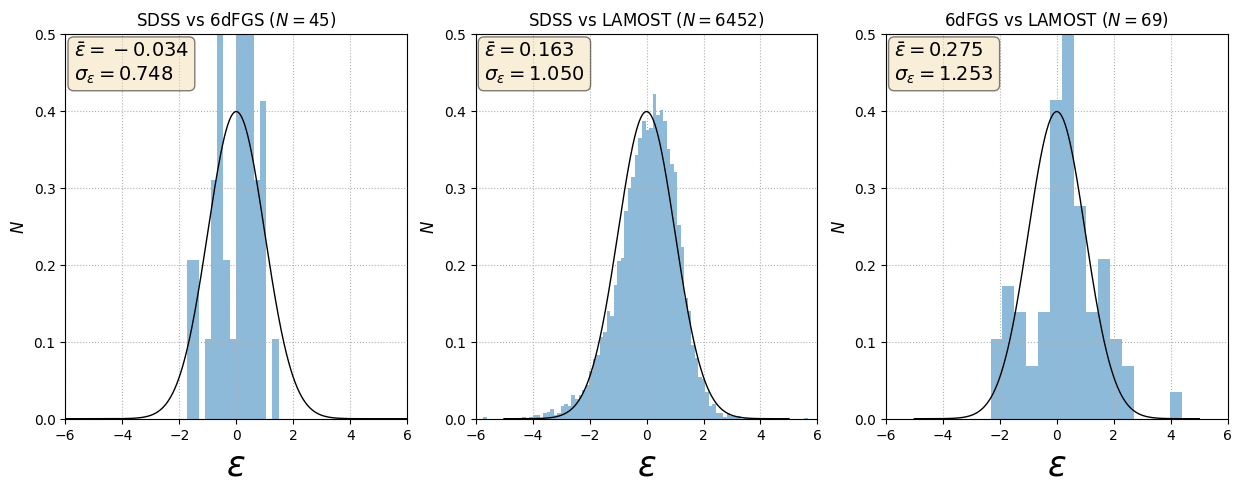

In [129]:
# Define the error scalings
k_sdss = 1.0
k_lamost = 2.593

# Define the offsets
Delta_6df = -0.02628138
Delta_lamost = 0.0

# Read the file
df = pd.read_csv('data/processed/veldisp_calibrated/repeat_ori.csv')
# Apply the scalings and offsets
df['s_6df'] -= Delta_6df
df['s_lamost'] -= Delta_lamost
df['es_sdss'] *= k_sdss
df['es_lamost'] *= k_lamost

# Store the velocity dispersions and errors in a single array
sig = df[['s_sdss', 's_6df', 's_lamost']].to_numpy().T
dsig = df[['es_sdss', 'es_6df', 'es_lamost']].to_numpy().T

# plt.rcParams["mathtext.fontset"] = "cm"

# sigma clipping
sigma_clip = 7.5
# offset clipping
delta_clip = 100.


#--------------------------------- SDSS vs 6dFGS -------------------------------------------------------#
## The discrepancy between s
delta = sig[0,:]-sig[1,:]
## Exclude erroneous measurements whose discrepancies are greater than delta_clip
cut = np.absolute(delta)<=delta_clip
epsilon = delta[cut]/np.sqrt(dsig[0,:][cut]**2+dsig[1,:][cut]**2)
## Remove nan values
epsilon = epsilon[~np.isnan(epsilon)]
## Apply sigma clipping
epsilon = epsilon[np.absolute(epsilon)<5.]

print('=============================SDSS vs 6dFGS=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

plt.figure(figsize=(15,5))
plt.subplot(131)

n_bins = 15
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

x_model = np.linspace(-6,6,1000)
y_model = norm.pdf(x_model,0,1)

plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
plt.title(r'SDSS vs 6dFGS ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon$',fontsize=25)
# plt.xlim(-4,4)
plt.xlim(-6,6)

plt.ylim(0,0.5)
plt.ylabel(r'$N$',fontsize=12)
# plt.text(-3,0.5,r'$\bar{\epsilon} = $ %.2f' % np.mean(epsilon))
textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-5.7, 0.49, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

#--------------------------------- SDSS vs LAMOST -------------------------------------------------------#
delta = sig[0,:]-sig[2,:]
cut = np.absolute(delta)<=delta_clip
epsilon = delta[cut]/np.sqrt(dsig[0,:][cut]**2+dsig[2,:][cut]**2)
epsilon = epsilon[~np.isnan(epsilon)]
epsilon = epsilon[np.absolute(epsilon)<sigma_clip]

print('=============================SDSS vs LAMOST=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

# plt.figure(figsize=(15,5))
# plt.subplot(131)

plt.subplot(132)

n_bins = 100
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

# fit with Gaussian
def gaus(x,mu,sig):
    return (1/np.sqrt(2*np.pi*sig**2))*np.exp(-0.5*((x-mu)/sig)**2)

y, x_edges = np.histogram(epsilon,bins=n_bins,density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus,x,y,p0=[0,1])
popt[1] = np.absolute(popt[1])

x_model = np.linspace(-5,5,1000)
y_model = norm.pdf(x_model,0,1)

plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
plt.title(r'SDSS vs LAMOST ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon$',fontsize=25)
plt.ylabel(r'$N$',fontsize=12)
# plt.xlim(-4,4)
plt.xlim(-6,6)
plt.ylim(0,0.5)

# textstr = '\n'.join((
#     r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
#     r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# plt.text(-3.8, 0.44, textstr, fontsize=14,
#         verticalalignment='top', bbox=props)

# Use the fitted Gaussian
textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % popt[0],
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-5.7,0.49, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

#--------------------------------- 6dFGS vs LAMOST -------------------------------------------------------#
epsilon = (sig[1,:]-sig[2,:])/np.sqrt(dsig[1,:]**2+dsig[2,:]**2)
epsilon = epsilon[~np.isnan(epsilon)]
epsilon = epsilon[epsilon<sigma_clip]

print('=============================6dFGS vs LAMOST=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

plt.subplot(133)

n_bins = 16
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

x_model = np.linspace(-5,5,1000)
y_model = norm.pdf(x_model,0,1)
plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
plt.title(r'6dFGS vs LAMOST ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon$',fontsize=25)
plt.ylabel(r'$N$',fontsize=12)
# plt.xlim(-4,4)
plt.xlim(-6,6)
plt.ylim(0,0.5)

textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-5.7, 0.49, textstr, fontsize=14,
        verticalalignment='top', bbox=props)
# plt.savefig('../../images/epsilon_after.png',dpi=400, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [51]:
# Check uniqueness of raw data
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df = Table(hdul[1].data).to_pandas()
print(f"Number of 6dFGS galaxies = {len(df)}. Uniqueness of raw 6dFGS = {df['_2MASX'].nunique() / len(df) * 100}")

df = pd.read_csv('data/raw/sdss/SDSS_spectro.csv')
print(f"Number of 6dFGS galaxies = {len(df)}. Uniqueness of raw SDSS = {df['objID'].nunique() / len(df) * 100}")

with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df = Table(hdul[1].data).to_pandas()
print(f"Number of LAMOST galaxies = {len(df)}. Uniqueness of raw SDSS = {df['obsid'].nunique() / len(df) * 100}")

print('\n')

# Check uniqueness of spectrophoto data
df = pd.read_csv('data/preprocessed/spectrophoto/6dfgs.csv')
print(f"Number of 6dFGS galaxies = {len(df)}. Uniqueness of raw 6dFGS = {df['_2MASX'].nunique() / len(df) * 100}")
df = pd.read_csv('data/preprocessed/spectrophoto/sdss.csv')
print(f"Number of SDSS galaxies = {len(df)}. Uniqueness of raw SDSS = {df['tmass'].nunique() / len(df) * 100}")


Number of 6dFGS galaxies = 11102. Uniqueness of raw 6dFGS = 100.0
Number of 6dFGS galaxies = 281711. Uniqueness of raw SDSS = 100.0
Number of LAMOST galaxies = 85861. Uniqueness of raw SDSS = 100.0


Number of 6dFGS galaxies = 11102. Uniqueness of raw 6dFGS = 100.0
Number of SDSS galaxies = 91175. Uniqueness of raw SDSS = 99.99122566493008


In [56]:
df = pd.read_csv('data/raw/2mass/sdss_tmass.csv', low_memory=False)
df = df[df.designation.notna()]
print(f"Number of SDSS galaxies = {len(df)}. Uniqueness of raw SDSS = {df['designation'].nunique() / len(df) * 100}")

Number of SDSS galaxies = 155621. Uniqueness of raw SDSS = 99.98522050365953


In [28]:
df = pd.read_csv('data/preprocessed/spectrophoto/lamost.csv')

df[df['z_lamost'] > 0.1]

,obsid,ra,dec,z_lamost,veldisp,veldisp_err,tmass,glon,glat,j_ba,...,log_r_h_smodel_h,log_r_h_model_h,fit_ok_h,log_r_h_app_k,log_r_h_smodel_k,log_r_h_model_k,fit_ok_k,tempel_counterpart,IDcl,zcl
11,8403109,121.591870,6.537230,0.145917,155.0,10.0,2MASXJ08062202+0632138,215.619,19.626,1.0,...,0.206,0.003,OK,0.363,0.363,0.167,OK,False,18785,0.10168
12,8403127,122.196880,6.555630,0.146207,226.0,17.0,2MASXJ08084721+0633199,215.887,20.172,1.0,...,0.323,0.130,OK,0.284,0.285,0.061,OK,True,18754,0.14705
14,8404157,122.699160,6.189530,0.294312,314.0,23.0,2MASXJ08104780+0611220,216.475,20.454,0.5,...,0.390,0.258,OK,0.454,0.436,0.320,OK,False,126,0.09873
16,8404197,122.783910,5.996560,0.153084,128.0,12.0,2MASXJ08110811+0559480,216.699,20.442,0.7,...,0.325,0.000,NOK,0.738,0.696,0.674,OK,False,2706,0.05070
17,8406103,125.266390,5.345520,0.129234,287.0,15.0,2MASXJ08210390+0520440,218.525,22.349,0.8,...,0.437,0.345,OK,0.311,0.311,0.120,OK,False,451,0.07940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62982,744004076,241.654375,4.941268,0.116241,360.0,25.0,2MASXJ16063707+0456281,16.391,38.563,0.7,...,0.403,0.249,OK,0.000,0.000,0.000,NOK,False,538,0.11665
62983,744004250,242.086590,5.456839,0.140165,256.0,16.0,2MASXJ16082077+0527245,17.239,38.458,0.5,...,0.492,0.378,OK,0.000,0.000,0.000,NOK,True,715,0.13961
62984,744006043,243.521583,5.382835,0.149578,294.0,18.0,2MASXJ16140514+0522580,18.074,37.189,0.8,...,0.524,0.435,OK,0.563,0.568,0.499,OK,True,944,0.14995
62991,746213012,227.314301,27.027955,0.119289,242.0,13.0,2MASXJ15091539+2701402,40.784,59.420,0.7,...,0.445,0.304,OK,0.410,0.407,0.240,OK,True,34444,0.12050


# CALCULATE MEAN TOTOFFS

6dFGS mean offset = -0.023864096905447642
6dFGS offset standard deviation = 0.004538394485890116
LAMOST mean offset = 0.00337597699059923
LAMOST offset standard deviation = 0.0006539341800931568


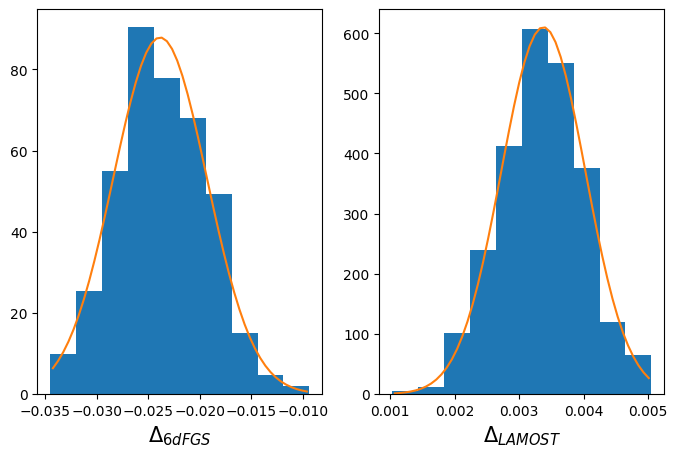

In [7]:
# Define gaussian function
def gaus(x, xmean, sigma):
    y = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-0.5 * ((x - xmean) / sigma)**2)
    return y

df = pd.read_csv('data/processed/veldisp_calibrated/totoffs.csv')

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=DEFAULT_FIGSIZE)

# Plot 6dFGS totoffs
off_6df = df.off_6df.to_numpy()

y, x_edges = np.histogram(off_6df, bins=50, density=True)
x = (x_edges[1:] + x_edges[:-1]) / 2
popt, pcov = curve_fit(gaus, x, y, p0=[np.mean(off_6df), np.std(off_6df)])
print(f'6dFGS mean offset = {popt[0]}')
print(f'6dFGS offset standard deviation = {popt[1]}')

ax1.hist(df.off_6df, bins=10, density=True)
ax1.plot(x, gaus(x, *popt))
ax1.set_xlabel(r'$\Delta_{6dFGS}$', fontsize=15)


# Plot LAMOST totoffs
off_lamost = df.off_lamost.to_numpy()

y, x_edges = np.histogram(off_lamost, bins=50, density=True)
x = (x_edges[1:] + x_edges[:-1]) / 2
popt, pcov = curve_fit(gaus, x, y, p0=[np.mean(off_lamost), np.std(off_lamost)])
print(f'LAMOST mean offset = {popt[0]}')
print(f'LAMOST offset standard deviation = {popt[1]}')

ax2.hist(df.off_lamost, bins=10, density=True)
ax2.plot(x, gaus(x, *popt))
ax2.set_xlabel(r'$\Delta_{LAMOST}$', fontsize=15)

plt.show()

# GENERATE BEFORE AND AFTER VELDISP CALIBRATION PLOT

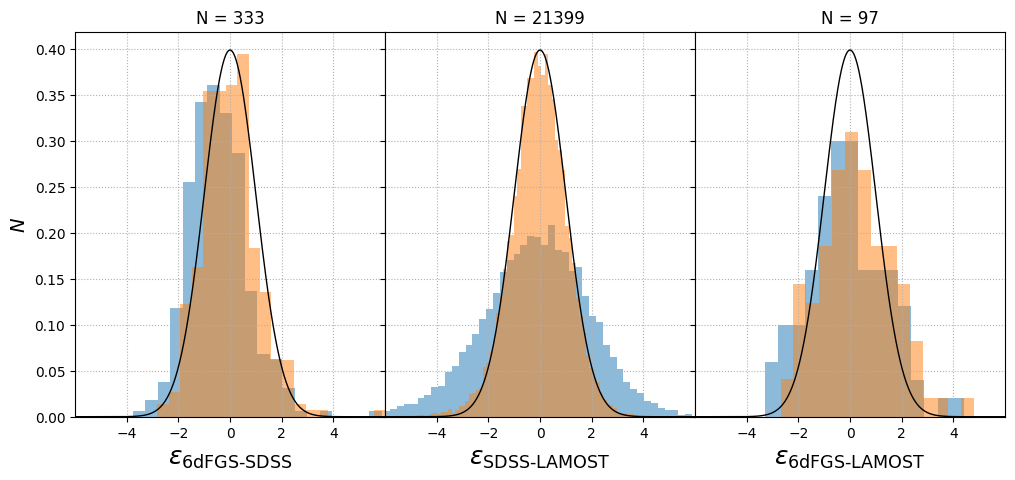

In [15]:
# # Previous results (5 sigma clipping)
k_sdss = 2.322
k_lamost = 1.666
off_6df = -0.024236101039486427
off_lamost = 0.0011588347531292854

# CONSTANTS
BIN_LIST = [20, 100, 15]
XLIM_LIST = [(-6, 6), (-6, 6), (-6, 6)]
XLABEL_LIST = [r'$\epsilon_\text{6dFGS-SDSS}$', r'$\epsilon_\text{SDSS-LAMOST}$', r'$\epsilon_\text{6dFGS-LAMOST}$']

df = pd.read_csv('data/processed/veldisp_calibrated/repeat_ori.csv')

# Apply the offsets
df['s_6df_scaled'] = df['s_6df'] - off_6df
df['es_6df_scaled'] = df['es_6df']
df['s_sdss_scaled'] = df['s_sdss']
df['es_sdss_scaled'] = df['es_sdss'] * k_sdss
df['s_lamost_scaled'] = df['s_lamost'] - off_lamost
df['es_lamost_scaled'] = df['es_lamost'] * k_lamost

# Calculate the epsilons (without offset)
df['epsilon_6df_sdss'] = (df['s_6df'] - df['s_sdss']) / np.sqrt(df['es_6df']**2 + df['es_sdss']**2)
df['epsilon_sdss_lamost'] = (df['s_sdss'] - df['s_lamost']) / np.sqrt(df['es_sdss']**2 + df['es_lamost']**2)
df['epsilon_6df_lamost'] = (df['s_6df'] - df['s_lamost']) / np.sqrt(df['es_6df']**2 + df['es_lamost']**2)
epsilon = df[['epsilon_6df_sdss', 'epsilon_sdss_lamost', 'epsilon_6df_lamost']]

# Calculate the epsilons (with offset)
df['epsilon_6df_sdss_scaled'] = (df['s_6df_scaled'] - df['s_sdss_scaled']) / np.sqrt(df['es_6df_scaled']**2 + df['es_sdss_scaled']**2)
df['epsilon_sdss_lamost_scaled'] = (df['s_sdss_scaled'] - df['s_lamost_scaled']) / np.sqrt(df['es_sdss_scaled']**2 + df['es_lamost_scaled']**2)
df['epsilon_6df_lamost_scaled'] = (df['s_6df_scaled'] - df['s_lamost_scaled']) / np.sqrt(df['es_6df_scaled']**2 + df['es_lamost_scaled']**2)
epsilon_scaled = df[['epsilon_6df_sdss_scaled', 'epsilon_sdss_lamost_scaled', 'epsilon_6df_lamost_scaled']]

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 5))
    
# Plot before and after scaling + offset
for i, ax in enumerate(axs):
    data = epsilon[epsilon.columns[i]].dropna()
    ax.hist(data, bins=BIN_LIST[i], density=True, alpha=0.5)
    
    data = epsilon_scaled[epsilon_scaled.columns[i]].dropna()
    ax.hist(data, bins=BIN_LIST[i], density=True, alpha=0.5)
    
    # Misc
    ax.grid(linestyle=":")
    ax.set_title(f'N = {len(data)}')
    ax.set_xlim(XLIM_LIST[i])
    ax.set_xlabel(XLABEL_LIST[i], fontsize=18)
    ax.set_xticks(ax.get_xticks()[1:-1])
    
    if i==0:
        ax.set_ylabel(r'$N$', fontsize=14)
    
# Plot standard normal Gaussians (target)
x = np.arange(start=-10., stop=10., step=0.0001)
y = norm.pdf(x, loc=0., scale=1.)
for ax in axs:
    ax.plot(x, y, c='k', lw=1.0)

plt.subplots_adjust(wspace=0)

plt.show()

# APPLY SELECTION CRITERIA

In [27]:
INPUT_FILEPATH = {
    '6dFGS': ('data/processed/veldisp_calibrated/6dfgs.csv'),
    'SDSS': ('data/processed/veldisp_calibrated/sdss.csv'),
    'LAMOST': ('data/processed/veldisp_calibrated/lamost.csv')
}

# Selection criteria constants
UPPER_Z_LIMIT = 16120.0 / LIGHTSPEED
LOWER_Z_LIMIT = 3000.0 / LIGHTSPEED
UPPER_MAG_LIMIT = 13.65
LOWER_VELDISP_LIMIT = np.log10(112)

for survey in SURVEY_LIST:
    df = pd.read_csv(INPUT_FILEPATH[survey])
    old_count = len(df)
    print(f"Original number of galaxies in {survey}: {old_count}")
    
    # Apply upper CMB redshift limit
    df = df[df['z_dist_est'] <= UPPER_Z_LIMIT]
    new_count = len(df)
    print(f"Number of galaxies after cz <= 16120 = {new_count} | Discarded galaxies = {old_count - new_count}")
    old_count = new_count
    
    # Apply upper magnitude limit
    df = df[(df['j_m_ext'] - df['extinction_j']) <= UPPER_MAG_LIMIT]
    new_count = len(df)
    print(f"Number of galaxies after (m_j - extinction_j) <= 13.65 = {new_count} | Discarded galaxies = {old_count - new_count}")
    old_count = new_count
    
    # Apply upper veldisp limit
    df = df[df['s_scaled'] >= LOWER_VELDISP_LIMIT]
    new_count = len(df)
    print(f"Number of galaxies after s_scaled >= log10(112) + 6dFGS_offset = {new_count} | Discarded galaxies = {old_count - new_count}")
    old_count = new_count
    
    # Apply lower CMB redshift limit
    df_high_z = df[df['z_dist_est'] >= LOWER_Z_LIMIT]
    new_count = len(df_high_z)
    print(f"Number of galaxies after cz >= 3000 = {new_count} | Discarded galaxies = {old_count - new_count}")
    
    # Save the remaining high-redshift galaxies
#     df_high_z.to_csv()
    
    # Save the low-redshift galaxies (will not be used to fit the FP due to high scatter but PVs will still be measured)
    df_low_z = df[df['z_dist_est'] <= LOWER_Z_LIMIT]
    print(f"Number of galaxies with cz <= 3000 = {len(df_low_z)}")
#     df_low_z.to_csv()

    print('\n')

Original number of galaxies in 6dFGS: 11102
Number of galaxies after cz <= 16120 = 10363 | Discarded galaxies = 739
Number of galaxies after (m_j - extinction_j) <= 13.65 = 9737 | Discarded galaxies = 626
Number of galaxies after s_scaled >= log10(112) + 6dFGS_offset = 9730 | Discarded galaxies = 7
Number of galaxies after cz >= 3000 = 9642 | Discarded galaxies = 88
Number of galaxies with cz <= 3000 = 88


Original number of galaxies in SDSS: 88955
Number of galaxies after cz <= 16120 = 24670 | Discarded galaxies = 64285
Number of galaxies after (m_j - extinction_j) <= 13.65 = 13142 | Discarded galaxies = 11528
Number of galaxies after s_scaled >= log10(112) + 6dFGS_offset = 11171 | Discarded galaxies = 1971
Number of galaxies after cz >= 3000 = 11154 | Discarded galaxies = 17
Number of galaxies with cz <= 3000 = 17


Original number of galaxies in LAMOST: 61693
Number of galaxies after cz <= 16120 = 12001 | Discarded galaxies = 49692
Number of galaxies after (m_j - extinction_j) <= 1

# SELECT ETG (skipped for now)

In [46]:

survey = 'LAMOST'
INPUT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/6dfgs.csv'),
    'SDSS': os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/sdss.csv'),
    'LAMOST': os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/lamost.csv')
}

HIGH_Z_OUTPUT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, 'data/processed/zms_cut/6dfgs.csv'),
    'SDSS': os.path.join(ROOT_PATH, 'data/processed/zms_cut/sdss.csv'),
    'LAMOST': os.path.join(ROOT_PATH, 'data/processed/zms_cut/lamost.csv')
}

LOW_Z_OUTPUT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, 'data/processed/zms_cut/low_z/6dfgs.csv'),
    'SDSS': os.path.join(ROOT_PATH, 'data/processed/zms_cut/low_z/sdss.csv'),
    'LAMOST': os.path.join(ROOT_PATH, 'data/processed/zms_cut/low_z/lamost.csv')
}

LAMOST_GOOD_PV_LIST_FILEPATH = os.path.join(ROOT_PATH, 'data/raw/r_e_jrl/lamost_good_pv_list.csv')

# Grab 6dFGS offset
totoff = pd.read_csv(os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/totoffs.csv'))
off_6df = 0.0 # totoff.loc[0, ['off_6df']].values[0]

# Selection criteria constants
UPPER_Z_LIMIT = 16120.0 / LIGHTSPEED
LOWER_Z_LIMIT = 3000.0 / LIGHTSPEED
UPPER_MAG_LIMIT = 13.65
LOWER_VELDISP_LIMIT = np.log10(112) - off_6df

print(f"{'=' * 25} {survey} {'=' * 25}")

df = pd.read_csv(INPUT_FILEPATH[survey])
old_count = len(df)
print(f"Original number of galaxies in {survey}: {old_count}")

# 1. Apply upper CMB redshift limit
df = df[df['z_dist_est'] <= UPPER_Z_LIMIT]
new_count = len(df)
print(f"Number of galaxies after cz <= 16120 = {new_count} | Discarded galaxies = {old_count - new_count}")
old_count = new_count

# 2. Apply lower CMB redshift limit
df_high_z = df[df['z_dist_est'] >= LOWER_Z_LIMIT]
new_count = len(df_high_z)
print(f"Number of galaxies after cz >= 3000 = {new_count} | Discarded galaxies = {old_count - new_count}")
old_count = new_count

# 3. Apply upper magnitude limit
df_high_z = df_high_z[(df_high_z['j_m_ext'] - df_high_z['extinction_j']) <= UPPER_MAG_LIMIT]
new_count = len(df_high_z)
print(f"Number of galaxies after (m_j - extinction_j) <= 13.65 = {new_count} | Discarded galaxies = {old_count - new_count}")
old_count = new_count

# 4. Apply upper veldisp limit
df_high_z = df_high_z[df_high_z['s_scaled'] >= LOWER_VELDISP_LIMIT]
new_count = len(df_high_z)
print(f"Number of galaxies after s_scaled >= log10(112) - 6dFGS_offset ({round(off_6df, 3)}) = {new_count} | Discarded galaxies = {old_count - new_count}")
old_count = new_count

# 5. Select the low-redshift galaxies (will not be used to fit the FP due to high scatter but PVs will still be measured)
df_low_z = df[(df['z_dist_est'] <= LOWER_Z_LIMIT) & ((df['j_m_ext'] - df['extinction_j']) <= UPPER_MAG_LIMIT) & (df['s_scaled'] >= LOWER_VELDISP_LIMIT)]

# 6. For LAMOST, select galaxies classified as ETG from John's visual inspections
if survey == 'LAMOST':
    good_pv_list = pd.read_csv(LAMOST_GOOD_PV_LIST_FILEPATH)[['col1']]
    df_high_z = df_high_z.merge(good_pv_list, left_on='tmass', right_on='col1', how='inner').drop(['col1'], axis=1)
    print(f"Number of LAMOST galaxies after visual inspection = {len(df_high_z)} | Discarded galaxies = {old_count - len(df_high_z)}")
    df_low_z = df_low_z.merge(good_pv_list, left_on='tmass', right_on='col1', how='inner').drop(['col1'], axis=1)
    
# Save the remaining high-redshift galaxies
df_high_z.to_csv(HIGH_Z_OUTPUT_FILEPATH[survey], index=False)

# Save the low-redshift galaxies
print(f"Number of galaxies with cz <= 3000 = {len(df_low_z)}")
df_low_z.to_csv(LOW_Z_OUTPUT_FILEPATH[survey], index=False)

print('\n')

========================= LAMOST =========================
Original number of galaxies in LAMOST: 61693
Number of galaxies after cz <= 16120 = 12001 | Discarded galaxies = 49692
Number of galaxies after cz >= 3000 = 11956 | Discarded galaxies = 45
Number of galaxies after (m_j - extinction_j) <= 13.65 = 4281 | Discarded galaxies = 7675
Number of galaxies after s_scaled >= log10(112) - 6dFGS_offset (0.0) = 3399 | Discarded galaxies = 882
Number of LAMOST galaxies after visual inspection = 2195 | Discarded galaxies = 1204
Number of galaxies with cz <= 3000 = 1




# DERIVE PHOTOMETRIC ERRORS

## Combine all the measurements

Iteration 1
Parameters: x0 = 10.2001
y0 = 0.0361
k = 0.0147
Constant = -0.1138
Iteration 2
Parameters: x0 = 11.0597
y0 = 0.0403
k = 0.0195
Constant = -0.1755
Iteration 3
Parameters: x0 = 10.9936
y0 = 0.039
k = 0.0195
Constant = -0.1755


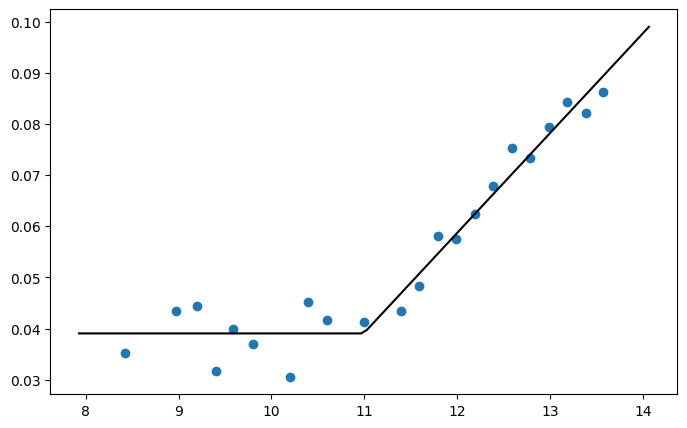

In [90]:
# Constant
MAG_BIN_WIDTH = 0.2    # magnitude bin width

INPUT_FILEPATH = {
    '6dFGS': 'data/processed/zms_cut/6dfgs.csv',
    'SDSS': 'data/processed/zms_cut/sdss.csv',
    'LAMOST': 'data/processed/zms_cut/lamost.csv'
}

df = pd.DataFrame()

for survey in SURVEY_LIST:
    req_cols = ['tmass', 'j_m_ext', 'extinction_j', 'i_j', 'i_h', 'i_k']
    df_survey = pd.read_csv(INPUT_FILEPATH[survey])[req_cols]
    df = pd.concat([df, df_survey])

df = df.drop_duplicates(subset='tmass')

# Calculate extinction-corrected J-band magnitude
df['mag_j'] = df['j_m_ext'] - df['extinction_j']

# Calculate all colors
df['color_jh'] = df['i_j'] - df['i_h']
df['color_jk'] = df['i_j'] - df['i_k']
df['color_hk'] = df['i_h'] - df['i_k']

# Create the magnitude bins
bin_list = np.arange(df['mag_j'].min(), df['mag_j'].max() + MAG_BIN_WIDTH, MAG_BIN_WIDTH)
bin_label = range(1, len(bin_list))
df['mag_j_bin'] = pd.cut(df['mag_j'], bin_list, labels=bin_label)

# Calculate the variance of the colors in each bin
delta2_jh = df.groupby('mag_j_bin', observed=False)['color_jh'].var()
delta2_jk = df.groupby('mag_j_bin', observed=False)['color_jk'].var()
delta2_hk = df.groupby('mag_j_bin', observed=False)['color_hk'].var()
mag_j_bin_mean = df.groupby('mag_j_bin', observed=False)['mag_j'].mean()

# Calculate the error in j alone
e_i_j = np.sqrt(0.5 * (delta2_jh + delta2_jk - delta2_hk))

# Remove nan values
notnan_indices = ~np.isnan(e_i_j)
e_i_j = e_i_j[notnan_indices].to_numpy()
mag_j_bin_mean = mag_j_bin_mean[notnan_indices].to_numpy()

# # Plot the data
# plt.figure(figsize=DEFAULT_FIGSIZE)
# plt.scatter(mag_j_bin_mean, e_i_j)

# Piecewise linear function
def piecewise_linear(x, x0, y0, k):
    y_pred = np.piecewise(x, [x < x0, x > x0], [lambda x: y0, lambda x: k * (x - x0) + y0])
    return y_pred

# Fit the function iteratively
x_data = mag_j_bin_mean
y_data = e_i_j
datacount = len(y_data)
is_converged = False
i = 1
while not is_converged:
    print(f"Iteration {i}")
    # Fit the parameters
    popt, pcov = curve_fit(piecewise_linear, x_data, y_data, p0=[11.0, 0.02, 0.05])
    print(f'Parameters: x0 = {round(popt[0], 4)}')
    print(f'y0 = {round(popt[1], 4)}')
    print(f'k = {round(popt[2], 4)}')
    print(f'Constant = {round(popt[1] - popt[2] * popt[0], 4)}')
#     print(f"Equation: y = {popt_j[2]:.4f}m_J + {constant_j:.4f} for x >= {popt_j[0]:.4f}")

    # Calculate the predicted values and chi statistics
    y_pred = piecewise_linear(x_data, *popt)
    chisq = ((y_data - y_pred) / y_pred)**2

    # Reject the 'bad' data (chisq > 0.5)
    bad_data_indices = chisq > 0.06
    x_data = x_data[~bad_data_indices]
    y_data = y_data[~bad_data_indices]
    datacount_new = len(y_data)

    is_converged = True if datacount == datacount_new else False
    datacount = datacount_new
    i += 1
    
# Plot the results
x_trial = np.linspace(np.min(x_data) - 0.5, np.max(x_data) + 0.5, 100)
y_trial = piecewise_linear(x_trial, *popt)

plt.figure(figsize=DEFAULT_FIGSIZE)
plt.scatter(x_data, y_data)
plt.plot(x_trial, y_trial, color='k')

plt.show()

Iteration 1
Parameters: x0 = 10.2001
y0 = 0.0361
k = 0.0147
Constant = -0.1138
Iteration 2
Parameters: x0 = 11.0597
y0 = 0.0403
k = 0.0195
Constant = -0.1755
Iteration 3
Parameters: x0 = 10.9936
y0 = 0.039
k = 0.0195
Constant = -0.1755


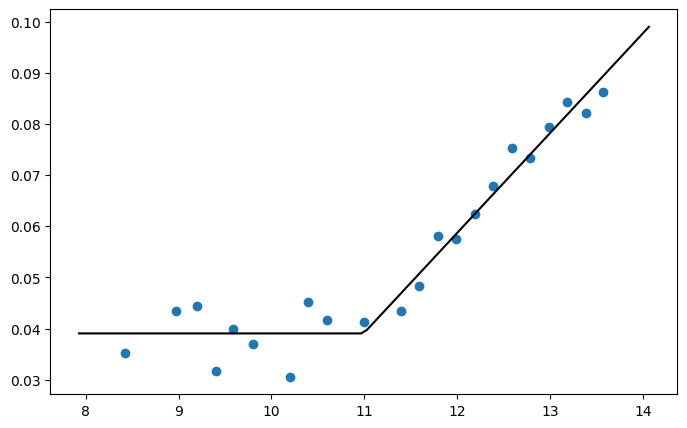

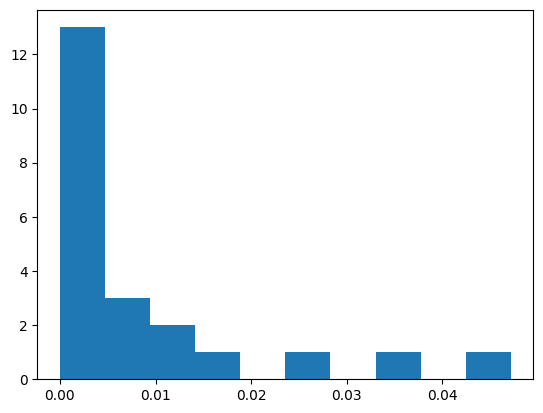

In [89]:
plt.hist(chisq)
plt.show()

In [6]:
pd.read_csv('data/raw/sdss/sdss_howlett2022.dat', delim_whitespace=True)

,PGC,coords,objid,specObjId,plate,RA,Dec,l,b,deVMag_g,...,s,es,i,ei,logdist,logdist_err,logdist_alpha,logdist_corr,logdist_corr_err,logdist_corr_alpha
0,1233903,J112934.7+023941,1237654030328922362,576621864177133568,512,172.394795,2.661484,260.750209,58.659639,17.54882,...,2.84734,0.01661,2.20262,0.01513,0.132164,0.102798,-0.576760,0.108613,0.102597,-0.680995
1,2180626,J161531.4+412425,1237659329777107022,1318559404106213120,1171,243.880668,41.407020,65.575776,46.176954,15.44160,...,3.32697,0.00634,2.29344,0.00724,0.046916,0.095898,-0.375417,0.027767,0.093567,-0.349573
2,3112054,J134427.9-001000,1237671957519794394,336665265779533824,299,206.116130,-0.166644,330.119970,59.876092,17.43604,...,2.75149,0.01837,2.29858,0.01343,0.021033,0.104337,-0.530621,0.003093,0.105062,-0.623428
3,3124224,J114611.6+032743,1237651755082580040,578859370373212160,514,176.548500,3.461874,266.736098,61.659548,17.88573,...,2.58515,0.02286,2.21004,0.02223,-0.018901,0.107711,-0.519613,-0.047273,0.108915,-0.598469
4,3122691,J114947.6+025635,1237671129127059618,578885758652278784,514,177.448413,2.942938,268.922247,61.674524,17.43210,...,2.79776,0.01599,2.26756,0.01529,-0.067468,0.104233,-0.550741,-0.087197,0.104653,-0.649119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34054,1824143,J135945.7+280117,1237665429169307943,2384816045723510784,2118,209.940589,28.021406,40.259214,74.845291,17.31200,...,2.86528,0.01266,2.23033,0.01420,0.085468,0.102212,-0.580367,0.139850,0.096897,-0.410401
34055,56786,J160218.0+162158,1237665531723317440,2472613143914768384,2196,240.575050,16.366201,29.418294,44.669599,15.29424,...,2.44175,0.00651,2.38024,0.00811,-0.060779,0.098943,-0.584279,-0.065817,0.095355,-0.438518
34056,58348,J162944.9+404842,1237655373573062713,919958120371873792,817,247.437155,40.811611,64.680181,43.506581,12.81371,...,2.48278,0.00446,2.46024,0.00579,0.225224,0.095139,-0.197331,0.221563,0.091369,-0.366103
34057,58191,J162741.1+405537,1237655472357114000,918822324826826880,816,246.921342,40.926966,64.835897,43.897452,13.70092,...,2.12474,0.00441,2.39683,0.00828,0.026271,0.096306,-0.476559,-0.000887,0.093916,-0.502596


In [25]:
# cols = pd.read_csv('data/raw/6dfgs/EDDtable18Mar2022035755.txt', header=1)
df = pd.read_csv('data/raw/6dfgs/EDDtable18Mar2022035755.txt')

df

,PGC,rej,1PGC,Nest,Name,Vcmb,Vgp,D75,D100,feD,DzDh,eDz,skew,RA,DE,Vg,Gp
0,27,1,27,0,g0000235-065610,10920,10920,145.5,109.2,0.27,0.015698,0.105029,-0.021398,0.0978,-6.9362,10920,-1
1,40,1,40,209793,g0000356-014547,6956,6956,116.4,87.3,0.31,-0.088660,0.118089,0.016330,0.1485,-1.7632,6956,-1
2,51,1,142,201987,g0000358-403432,14746,14746,248.6,186.5,0.42,-0.081111,0.152326,0.015862,0.1489,-40.5756,14746,-1
3,64,0,72642,200033,g0000523-355037,15324,14646,222.3,166.7,0.29,-0.034659,0.110224,0.010894,0.2181,-35.8437,14646,1261
4,66,0,72642,200033,g0000532-355911,14725,14646,191.0,143.2,0.27,0.030506,0.103811,-0.028422,0.2216,-35.9863,14646,1261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8880,4684754,0,4684754,210660,g0944459-715759,6624,6624,78.0,58.5,0.29,0.063476,0.111263,-0.023519,146.1912,-71.9665,6624,-1
8881,4684803,0,4684803,208156,g1937242-174502,9189,9189,153.4,115.1,0.27,-0.084619,0.102455,0.033847,294.3507,-17.7505,9189,-1
8882,4684804,0,4684804,208117,g1934263-174833,9163,9163,89.0,66.8,0.32,0.150652,0.121477,-0.057482,293.6096,-17.8093,9163,-1
8883,4684828,0,4684828,0,g1939071-155316,15569,15569,247.6,185.7,0.31,-0.054598,0.116297,0.030770,294.7795,-15.8876,15569,-1


In [10]:
cols

Index(['PGC', 'rej', '1PGC', 'Nest', 'Name', 'Vcmb', 'Vgp', 'D75', 'D100',
       'feD', 'DzDh', 'eDz', 'skew', 'RA', 'DE', 'Vg', 'Gp'],
      dtype='object')